In [ ]:
#load libraries
library(Seurat)
#library(tidyverse)
library(ggplot2)
library(scales)
library(dplyr)
library(openxlsx)
library(HGNChelper)
set.seed(411)
print("m")

library(patchwork)

 
#seur_obj <- readRDS("quobyte/from-lssc0/projects/NCR_scRNAseq/results/seurat/harmony_22jan_.rds") #reg processing + wnn
seur_obj <- readRDS("/quobyte/bmhenngrp/from-lssc0/projects/NCR_scRNAseq/results/seurat/3_harmonize_batches_wgs/raw_merge_all_batches_harm_annotated_all_res5_pca50.rds") #reg processing + wnn
   
    
    #NCR_scRNAseq/results/seurat/
     
print("read file")
head(seur_obj)


# load gene set preparation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# load cell type annotation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")


# DB file
db_ <- "https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_full.xlsx";
tissue <- "Immune system" # e.g. Immune system,Pancreas,Liver,Eye,Kidney,Brain,Lung,Adrenal,Heart,Intestine,Muscle,Placenta,Spleen,Stomach,Thymus 

# prepare gene sets
gs_list <- gene_sets_prepare(db_, tissue)



# check Seurat object version (scRNA-seq matrix extracted differently in Seurat v4/v5)
seurat_package_v5 <- isFALSE('counts' %in% names(attributes(seur_obj[["RNA"]])));
print(sprintf("Seurat object %s is used", ifelse(seurat_package_v5, "v5", "v4")))

# extract scaled scRNA-seq matrix
scRNAseqData_scaled <- if (seurat_package_v5) as.matrix(seur_obj[["RNA"]]$scale.data) else as.matrix(seur_obj[["RNA"]]@scale.data)

# run ScType
es.max <- sctype_score(scRNAseqData = scRNAseqData_scaled, scaled = TRUE, gs = gs_list$gs_positive, gs2 = gs_list$gs_negative)

# NOTE: scRNAseqData parameter should correspond to your input scRNA-seq matrix. For raw (unscaled) count matrix set scaled = FALSE
# When using Seurat, we use "RNA" slot with 'scale.data' by default. Please change "RNA" to "SCT" for sctransform-normalized data,
# or to "integrated" for joint dataset analysis. To apply sctype with unscaled data, use e.g. seur_obj[["RNA"]]$counts or seur_obj[["RNA"]]@counts, with scaled set to FALSE.

# merge by cluster
cL_resutls <- do.call("rbind", lapply(unique(seur_obj@meta.data$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(seur_obj@meta.data[seur_obj@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(seur_obj@meta.data$seurat_clusters==cl)), 10)
}))
sctype_scores <- cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

# set low-confident (low ScType score) clusters to "unknown"
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] <- "Unknown"
print(sctype_scores[,1:3])

In [ ]:
seur_obj@meta.data$sctype_classification_man = ""
for(j in unique(sctype_scores$cluster)){
  cl_type = sctype_scores[sctype_scores$cluster==j,]; 
  seur_obj@meta.data$sctype_classification_man[seur_obj@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
}

DimPlot(seur_obj, reduction = "umap", label = TRUE, repel = TRUE, group.by = 'sctype_classification_man')        


In [7]:
# load libraries
lapply(c("ggraph","igraph","tidyverse", "data.tree"), library, character.only = T)


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()       masks igraph::%--%()
✖ tibble::as_data_frame() masks igraph::as_data_frame(), dplyr::as_data_frame()
✖ readr::col_factor()     masks scales::col_factor()
✖ purrr::compose()        masks igraph::compose()
✖ tidyr::crossing()       m

ERROR: Error in FUN(X[[i]], ...): there is no package called ‘data.tree’


In [ ]:
# prepare edges
cL_resutls <- cL_resutls[order(cL_resutls$cluster),]; edges = cL_resutls; edges$type = paste0(edges$type,"_",edges$cluster); edges$cluster = paste0("cluster ", edges$cluster); edges = edges[,c("cluster", "type")]; colnames(edges) = c("from", "to"); rownames(edges) <- NULL

# prepare nodes
nodes_lvl1 <- sctype_scores[,c("cluster", "ncells")]; nodes_lvl1$cluster = paste0("cluster ", nodes_lvl1$cluster); nodes_lvl1$Colour = "#f1f1ef"; nodes_lvl1$ord = 1; nodes_lvl1$realname = nodes_lvl1$cluster; nodes_lvl1 = as.data.frame(nodes_lvl1); nodes_lvl2 = c(); 
ccolss <- c("#5f75ae","#92bbb8","#64a841","#e5486e","#de8e06","#eccf5a","#b5aa0f","#e4b680","#7ba39d","#b15928","#ffff99", "#6a3d9a","#cab2d6","#ff7f00","#fdbf6f","#e31a1c","#fb9a99","#33a02c","#b2df8a","#1f78b4","#a6cee3")
for (i in 1:length(unique(cL_resutls$cluster))){
  dt_tmp = cL_resutls[cL_resutls$cluster == unique(cL_resutls$cluster)[i], ]; nodes_lvl2 = rbind(nodes_lvl2, data.frame(cluster = paste0(dt_tmp$type,"_",dt_tmp$cluster), ncells = dt_tmp$scores, Colour = ccolss[i], ord = 2, realname = dt_tmp$type))
}
nodes <- rbind(nodes_lvl1, nodes_lvl2); nodes$ncells[nodes$ncells<1] = 1;
files_db <- openxlsx::read.xlsx(db_)[,c("cellName","shortName")]; files_db = unique(files_db); nodes = merge(nodes, files_db, all.x = T, all.y = F, by.x = "realname", by.y = "cellName", sort = F)
nodes$shortName[is.na(nodes$shortName)] = nodes$realname[is.na(nodes$shortName)]; nodes = nodes[,c("cluster", "ncells", "Colour", "ord", "shortName", "realname")]

mygraph <- graph_from_data_frame(edges, vertices=nodes)

# Make the graph
gggr <- ggraph(mygraph, layout = 'circlepack', weight=I(ncells)) + 
  geom_node_circle(aes(filter=ord==1,fill=I("#F5F5F5"), colour=I("#D3D3D3")), alpha=0.9) + geom_node_circle(aes(filter=ord==2,fill=I(Colour), colour=I("#D3D3D3")), alpha=0.9) +
  theme_void() + geom_node_text(aes(filter=ord==2, label=shortName, colour=I("#ffffff"), fill="white", repel = !1, parse = T, size = I(log(ncells,25)*1.5)))+ geom_node_label(aes(filter=ord==1,  label=shortName, colour=I("#000000"), size = I(3), fill="white", parse = T), repel = !0, segment.linetype="dotted")
  
DimPlot(pbmc, reduction = "umap", label = TRUE, repel = TRUE, cols = ccolss)+ gggr

In [ ]:
str(seur_obj)

In [ ]:
# Filter Seurat object
#seur_obj <- subset(seur_obj, subset = !is.na(donor_id))
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_wrapper.R"); 
seur_obj <- run_sctype(seur_obj, assay = "RNA", scaled = TRUE, known_tissue_type="Immune system",custom_marker_file="https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_short.xlsx",name="sctype_classification")

#unique(seur_obj$sctype_classification)

In [9]:
head(seur_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,percent.mt,percent.ribo,platelet_score,cell,donor_id,prob_max,singlet_source_vireo,batch,RNA_snn_res.1.2,seurat_clusters,sctype_classification
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>
AAACCTGAGAAGATTC-1_1_1_1_1_1,TBSS01,4136,1729,2020,130,2.296905,23.50097,0,AAACCTGAGAAGATTC-1,donor11,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGAGACCTAGG-1_1_1_1_1_1,TBSS01,4861,1746,2246,131,2.201193,33.98478,0,AAACCTGAGACCTAGG-1,donor8,1,SNG,batch1_paths,2,2,CD8+ NKT-like cells
AAACCTGAGACTGTAA-1_1_1_1_1_1,TBSS01,1726,836,1788,128,3.707995,32.09733,0,AAACCTGAGACTGTAA-1,donor0,1,SNG,batch1_paths,14,14,γδ-T cells
AAACCTGAGAGACTAT-1_1_1_1_1_1,TBSS01,2233,1182,2072,134,1.612181,21.45096,0,AAACCTGAGAGACTAT-1,donor14,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGAGAGTGACC-1_1_1_1_1_1,TBSS01,1722,843,933,124,3.890825,30.66202,0,AAACCTGAGAGTGACC-1,donor4,1,SNG,batch1_paths,2,2,CD8+ NKT-like cells
AAACCTGAGATCTGCT-1_1_1_1_1_1,TBSS01,1346,755,1015,123,5.126300,28.82615,0,AAACCTGAGATCTGCT-1,donor28,1,SNG,batch1_paths,11,11,ISG expressing immune cells


In [10]:
seur_obj@meta.data$sctype_classification <- gsub(
  pattern = "γδ-T cells", 
  replacement = "Gamma-delta T cells", 
  seur_obj@meta.data$sctype_classification
)

In [11]:
nk_cells <- subset(seur_obj, subset = sctype_classification == 'Natural killer  cells')
head(nk_cells)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,percent.mt,percent.ribo,platelet_score,cell,donor_id,prob_max,singlet_source_vireo,batch,RNA_snn_res.1.2,seurat_clusters,sctype_classification
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>
AAACCTGAGAAGATTC-1_1_1_1_1_1,TBSS01,4136,1729,2020,130,2.296905,23.50097,0,AAACCTGAGAAGATTC-1,donor11,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGAGAGACTAT-1_1_1_1_1_1,TBSS01,2233,1182,2072,134,1.612181,21.45096,0,AAACCTGAGAGACTAT-1,donor14,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGCAGCTCGCA-1_1_1_1_1_1,TBSS01,1593,855,3266,136,9.353421,20.52731,0,AAACCTGCAGCTCGCA-1,donor14,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGGTACTCGCG-1_1_1_1_1_1,TBSS01,1413,801,1890,133,2.193914,22.71762,0,AAACCTGGTACTCGCG-1,donor11,1,SNG,batch1_paths,8,8,Natural killer cells
AAACCTGGTTTAGCTG-1_1_1_1_1_1,TBSS01,1248,770,1320,123,3.605769,15.70513,0,AAACCTGGTTTAGCTG-1,donor19,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGGTTTAGGAA-1_1_1_1_1_1,TBSS01,2095,1166,970,130,2.052506,15.36993,0,AAACCTGGTTTAGGAA-1,donor25,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGTCAAACAAG-1_1_1_1_1_1,TBSS01,5377,1912,2158,134,3.180212,32.36005,0,AAACCTGTCAAACAAG-1,donor17,1,SNG,batch1_paths,1,1,Natural killer cells
AAACCTGTCAGCTCTC-1_1_1_1_1_1,TBSS01,1433,890,2603,133,4.535939,19.05094,0,AAACCTGTCAGCTCTC-1,donor5,1,SNG,batch1_paths,8,8,Natural killer cells
AAACCTGTCATGTCCC-1_1_1_1_1_1,TBSS01,4035,1422,1138,124,3.469641,36.05948,0,AAACCTGTCATGTCCC-1,donor23,1,SNG,batch1_paths,1,1,Natural killer cells


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



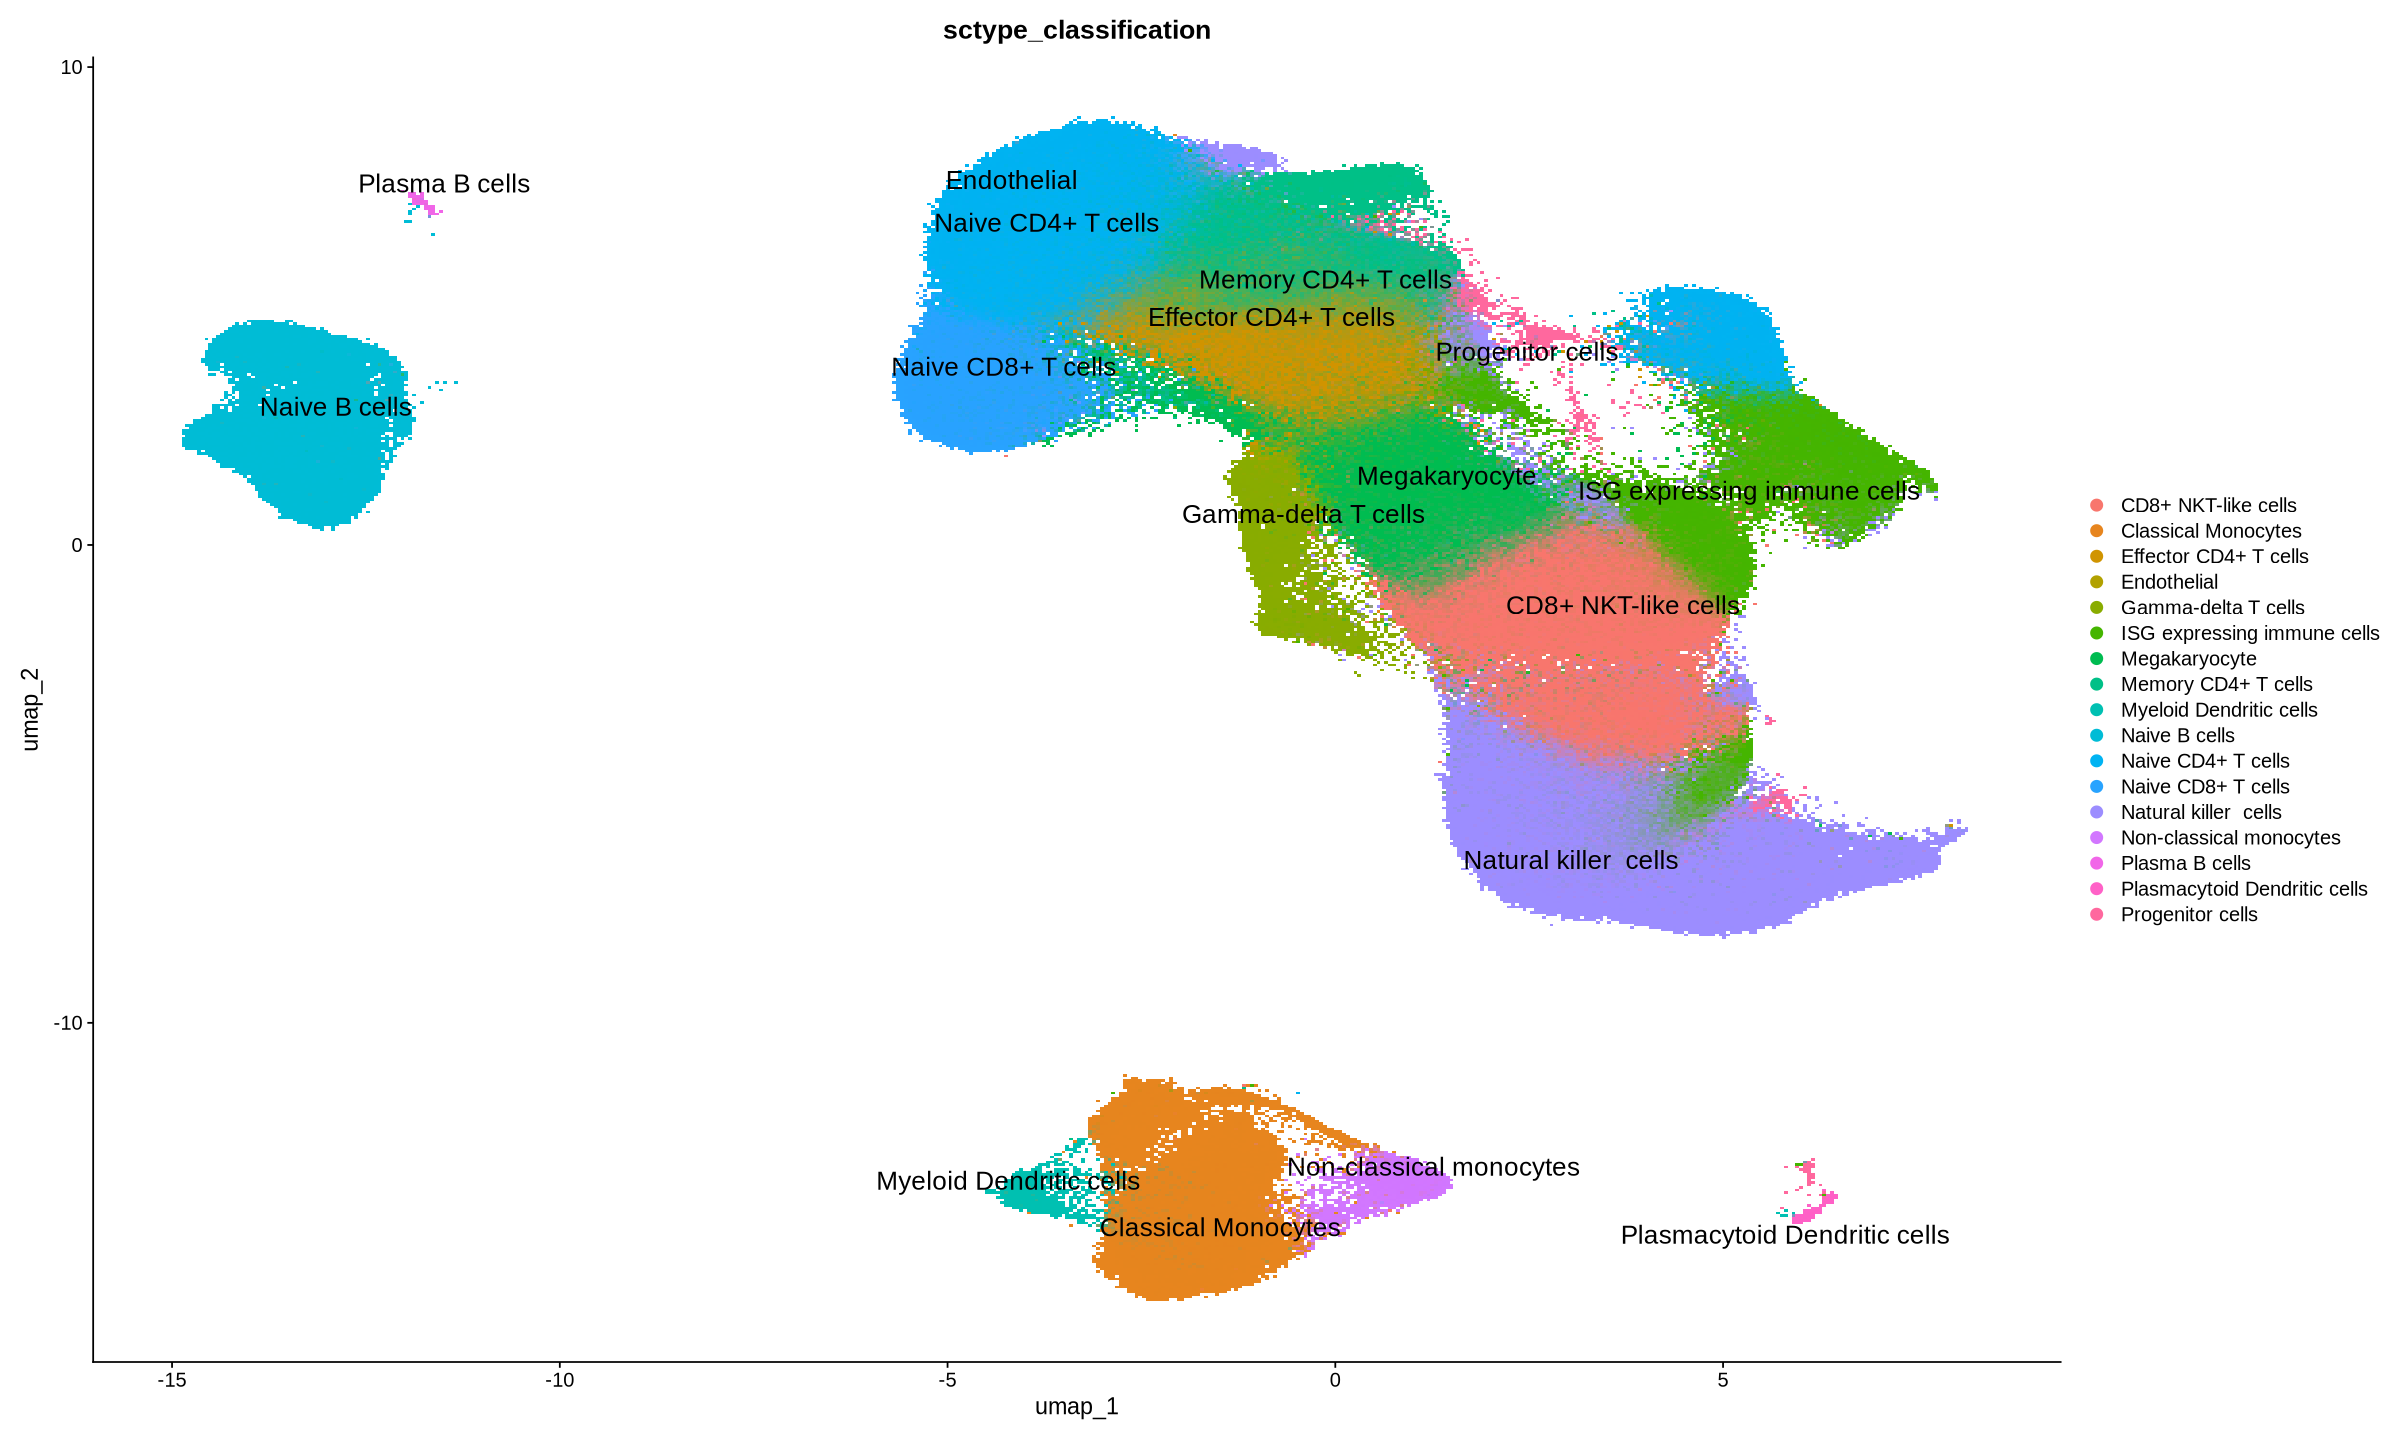

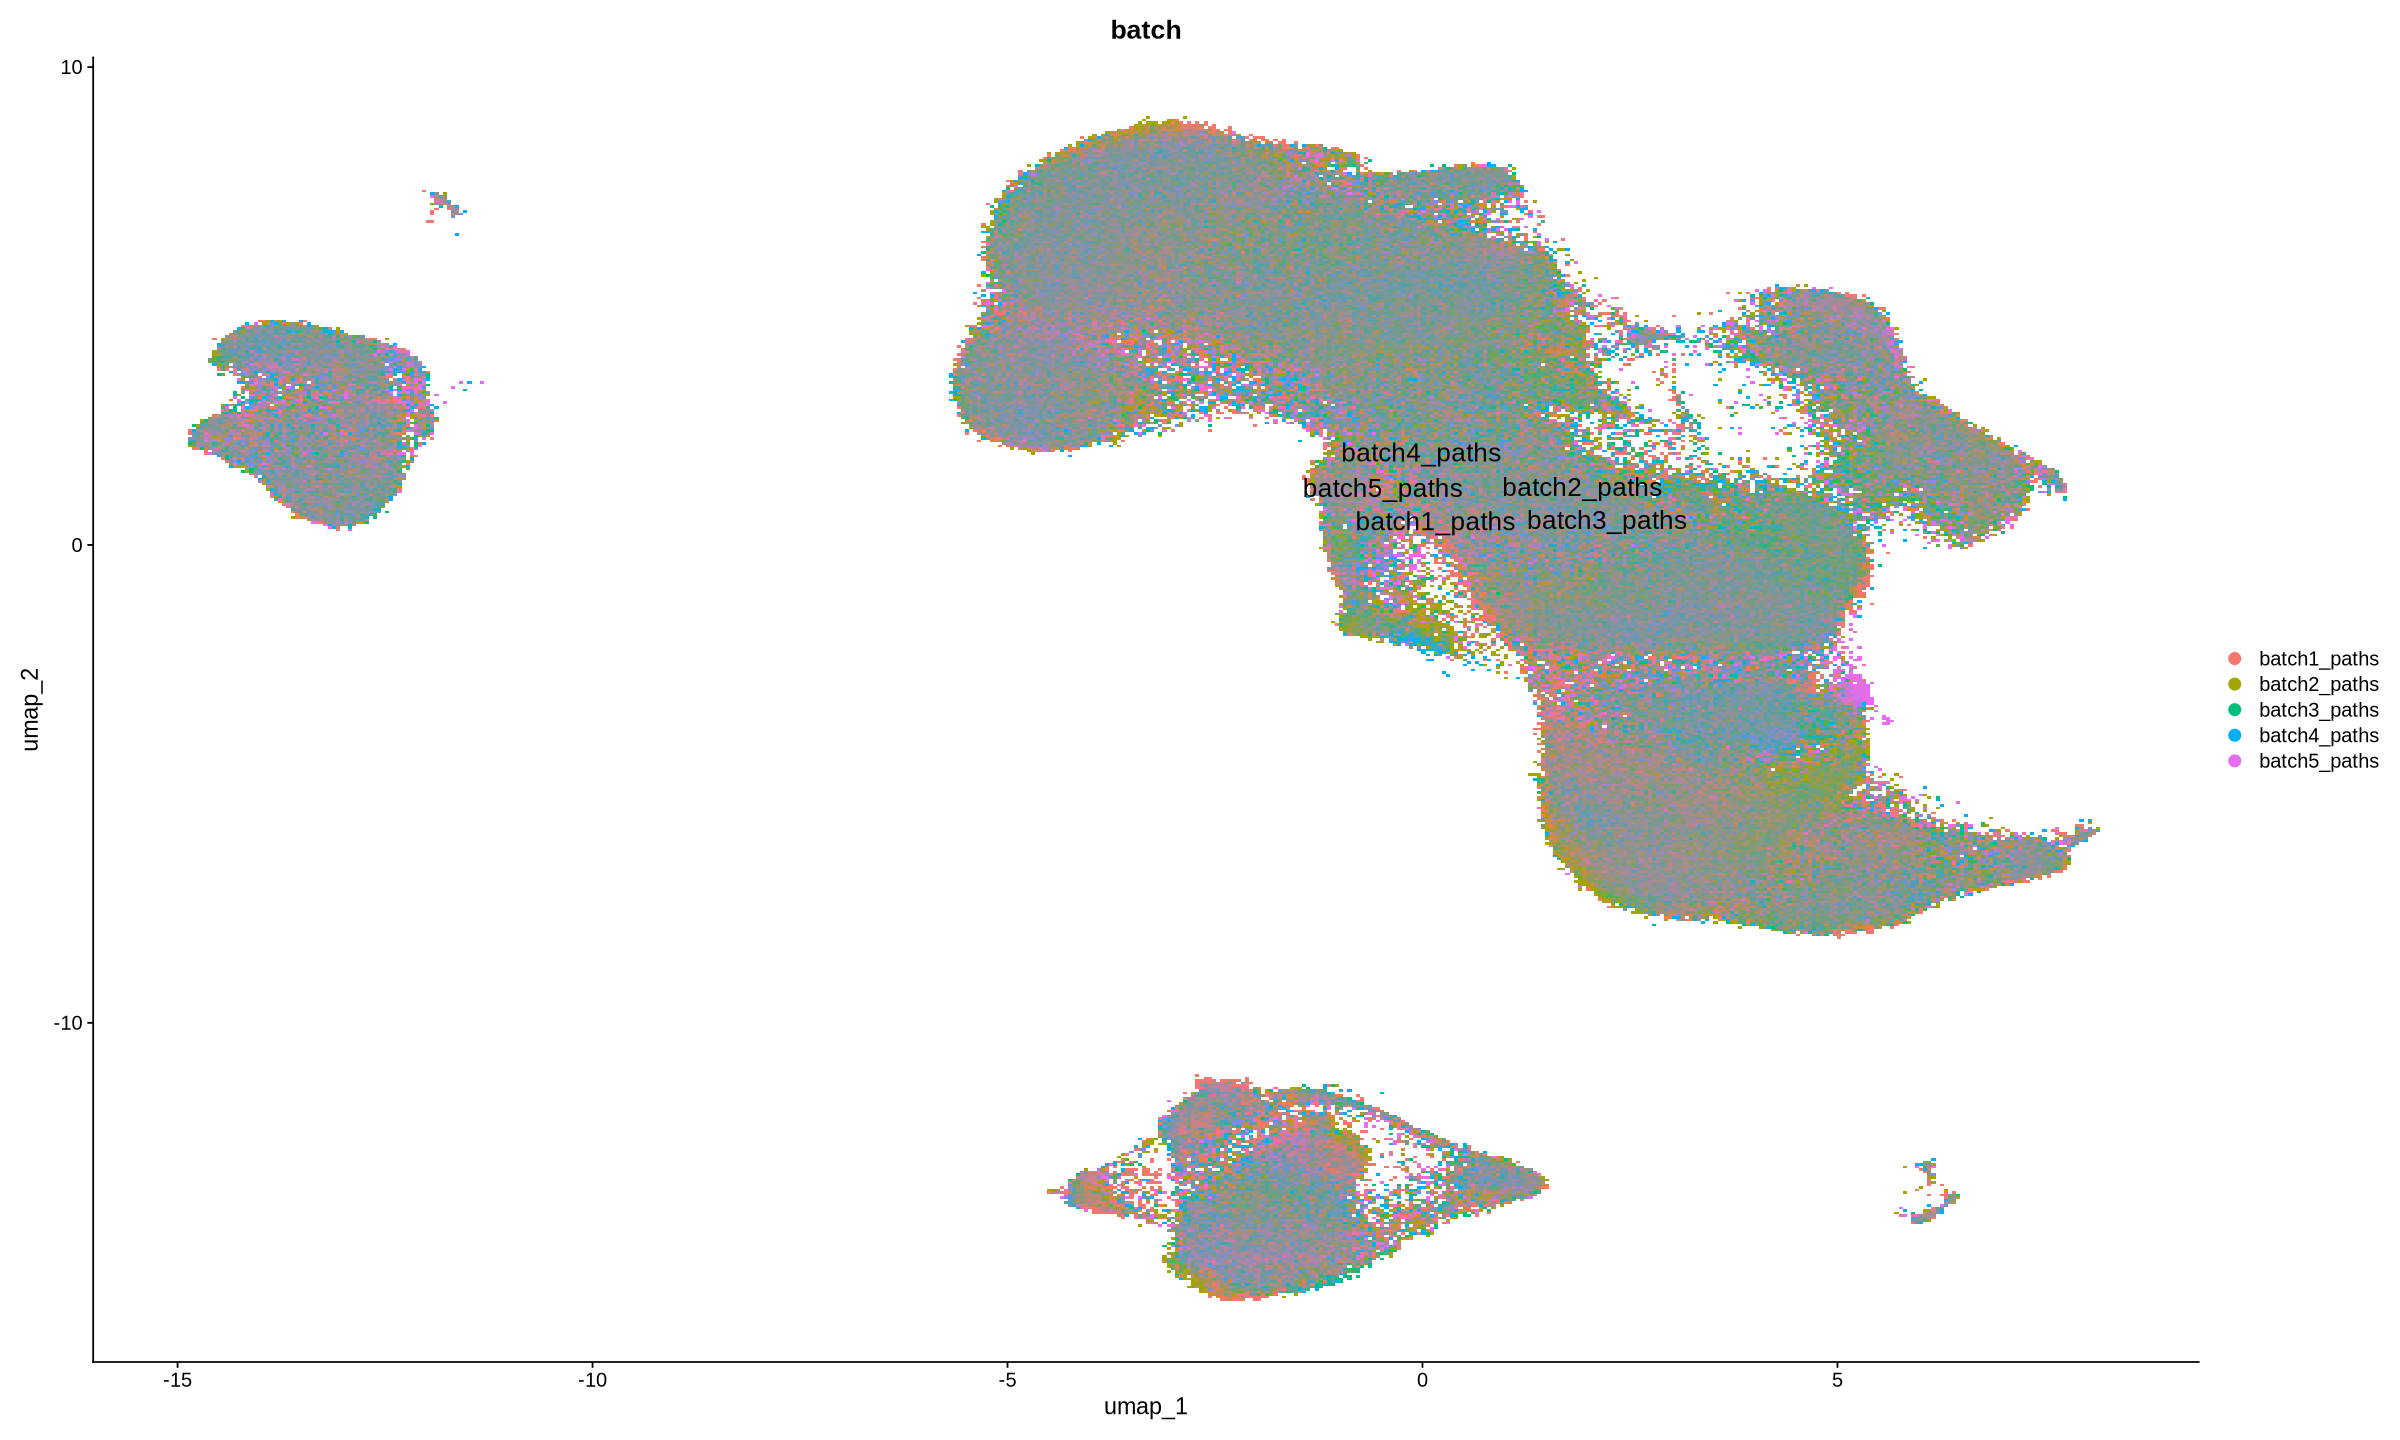

In [16]:
# Visualize the UMAPS
options(repr.plot.width = 20, repr.plot.height = 12)
DimPlot(seur_obj, reduction = 'umap', group.by = "sctype_classification",  label = TRUE, repel = TRUE, label.size = 5.5) 
DimPlot(seur_obj, reduction = 'umap', group.by = "batch",  label = TRUE, repel = TRUE, label.size = 5.5) 

In [8]:
DotPlot(nk_cells, features = "THBD1", group.by = "sctype_classification") + RotatedAxis()
VlnPlot(seur_obj, features = "THBD1", group.by = "sctype_classification", pt.size = 0)  # Set pt.size > 0 to show individual points

#DimPlot(seur_obj, reduction = 'adt.umap',   label = TRUE, repel = TRUE, label.size = 5.5) 

ERROR: [1m[33mError[39m in `FetchData()`:[22m
[33m![39m None of the requested variables were found: THBD1


In [ ]:
# Process RNA data with standard workflow
nk_cells_repro <- NormalizeData(nk_cells, assay = "RNA", normalization.method = "LogNormalize") %>%
  FindVariableFeatures(assay = "RNA", selection.method = "vst", nfeatures = 2000) %>%    # Specify RNA assay for variable feature selection
  ScaleData(assay = "RNA") %>%               # Specify RNA assay for scaling
  RunPCA(assay = "RNA",reduction.name = "pca", reduction.key = "PCA_") %>% # Specify RNA assay for PCA
  FindNeighbors(assay = "RNA", dims = 1:50)  %>%
  FindClusters(assay = "RNA",  resolution = 1.2)  %>%
  RunUMAP(reduction = 'pca', dims = 1:50, assay = 'RNA', 
              reduction.name = 'rna.umap', reduction.key = 'rnaUMAP_')
print("processed combined RNA data")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



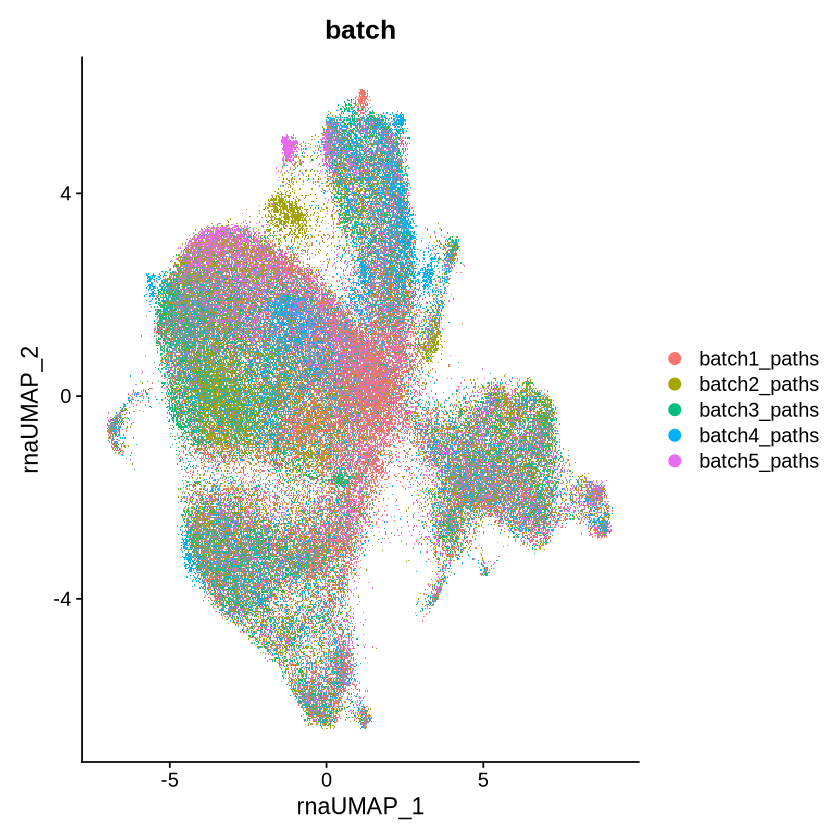

In [12]:
print(DimPlot(nk_cells_repro, reduction = "rna.umap", group.by = "batch"))
#print(DimPlot(nk_cells_repro, reduction = "rna.umap", group.by = "percent.mt"))
#print(DimPlot(nk_cells_repro, reduction = "rna.umap", group.by = "percent.ribo"))

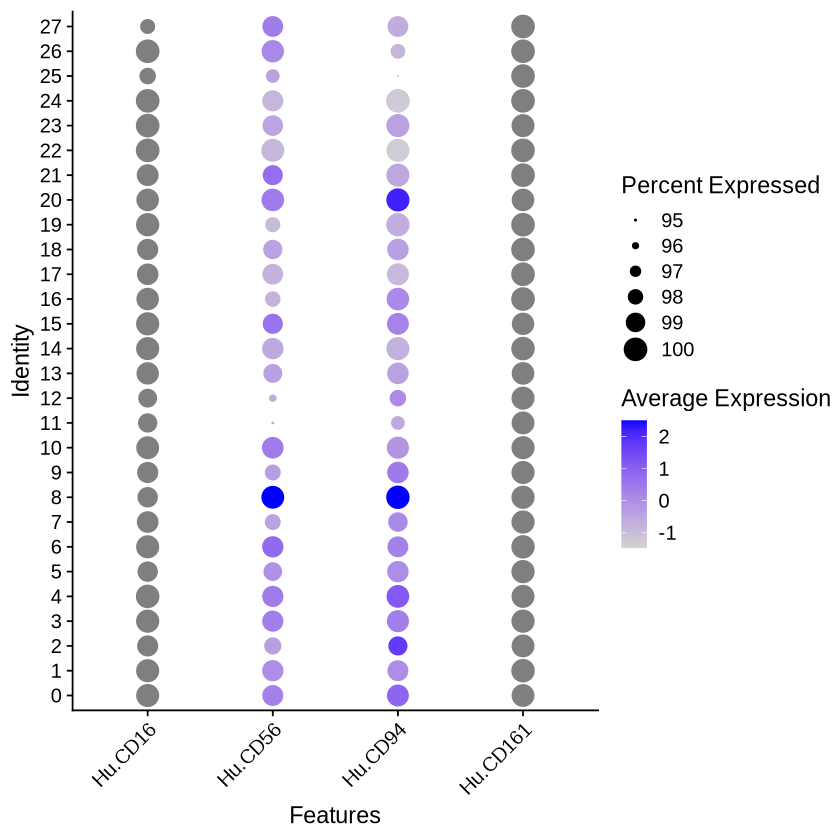

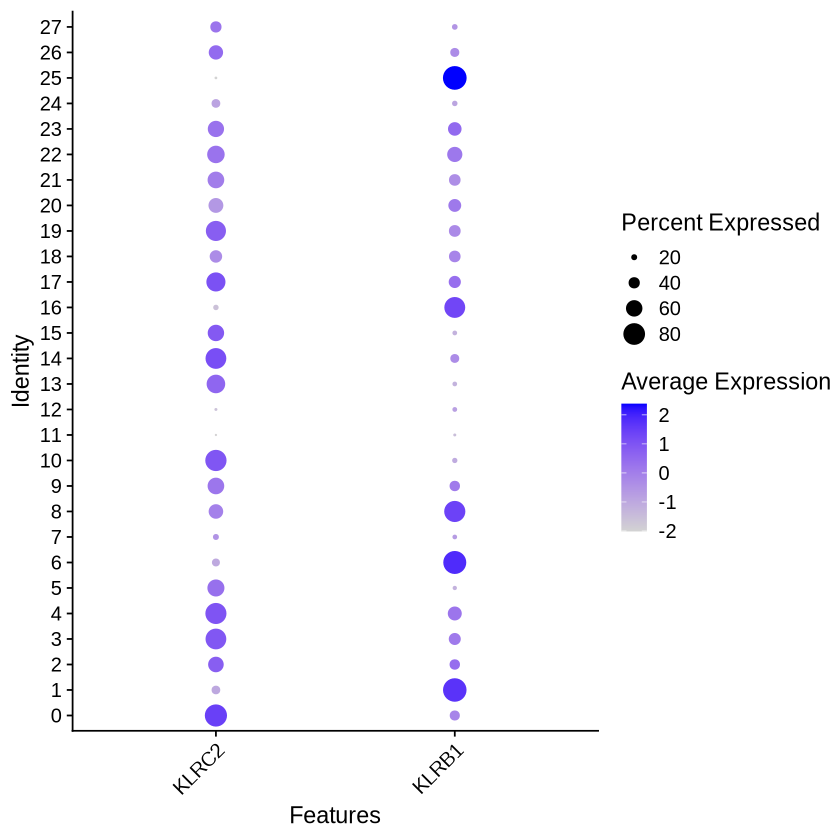

In [16]:
DotPlot(nk_cells_repro, features = c("Hu.CD16", "Hu.CD56", "Hu.CD94", "Hu.CD161"), 
        assay = "ADT") + RotatedAxis()
DotPlot(nk_cells_repro, features = c("KLRC2", "KLRB1"), 
        assay = "RNA") + RotatedAxis()



In [ ]:
#saveRDS(nk_cells_repro, "nk_cells_filtered.rds")
FeaturePlot(nk_cells_repro, features = c("Hu.CD16", "Hu.CD56", "Hu.CD94", "Hu.CD161"), 
            reduction = "rna.umap" )

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



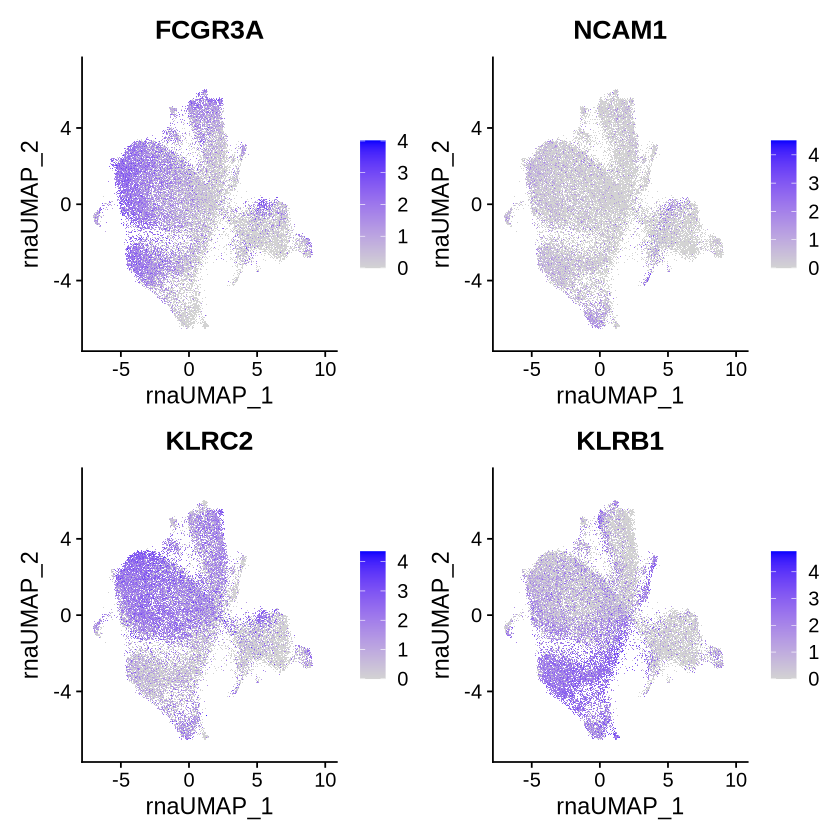

In [20]:
FeaturePlot(nk_cells_repro, features = c("FCGR3A",
"NCAM1",
"KLRC2",
"KLRB1"), 
            reduction = "rna.umap" )

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



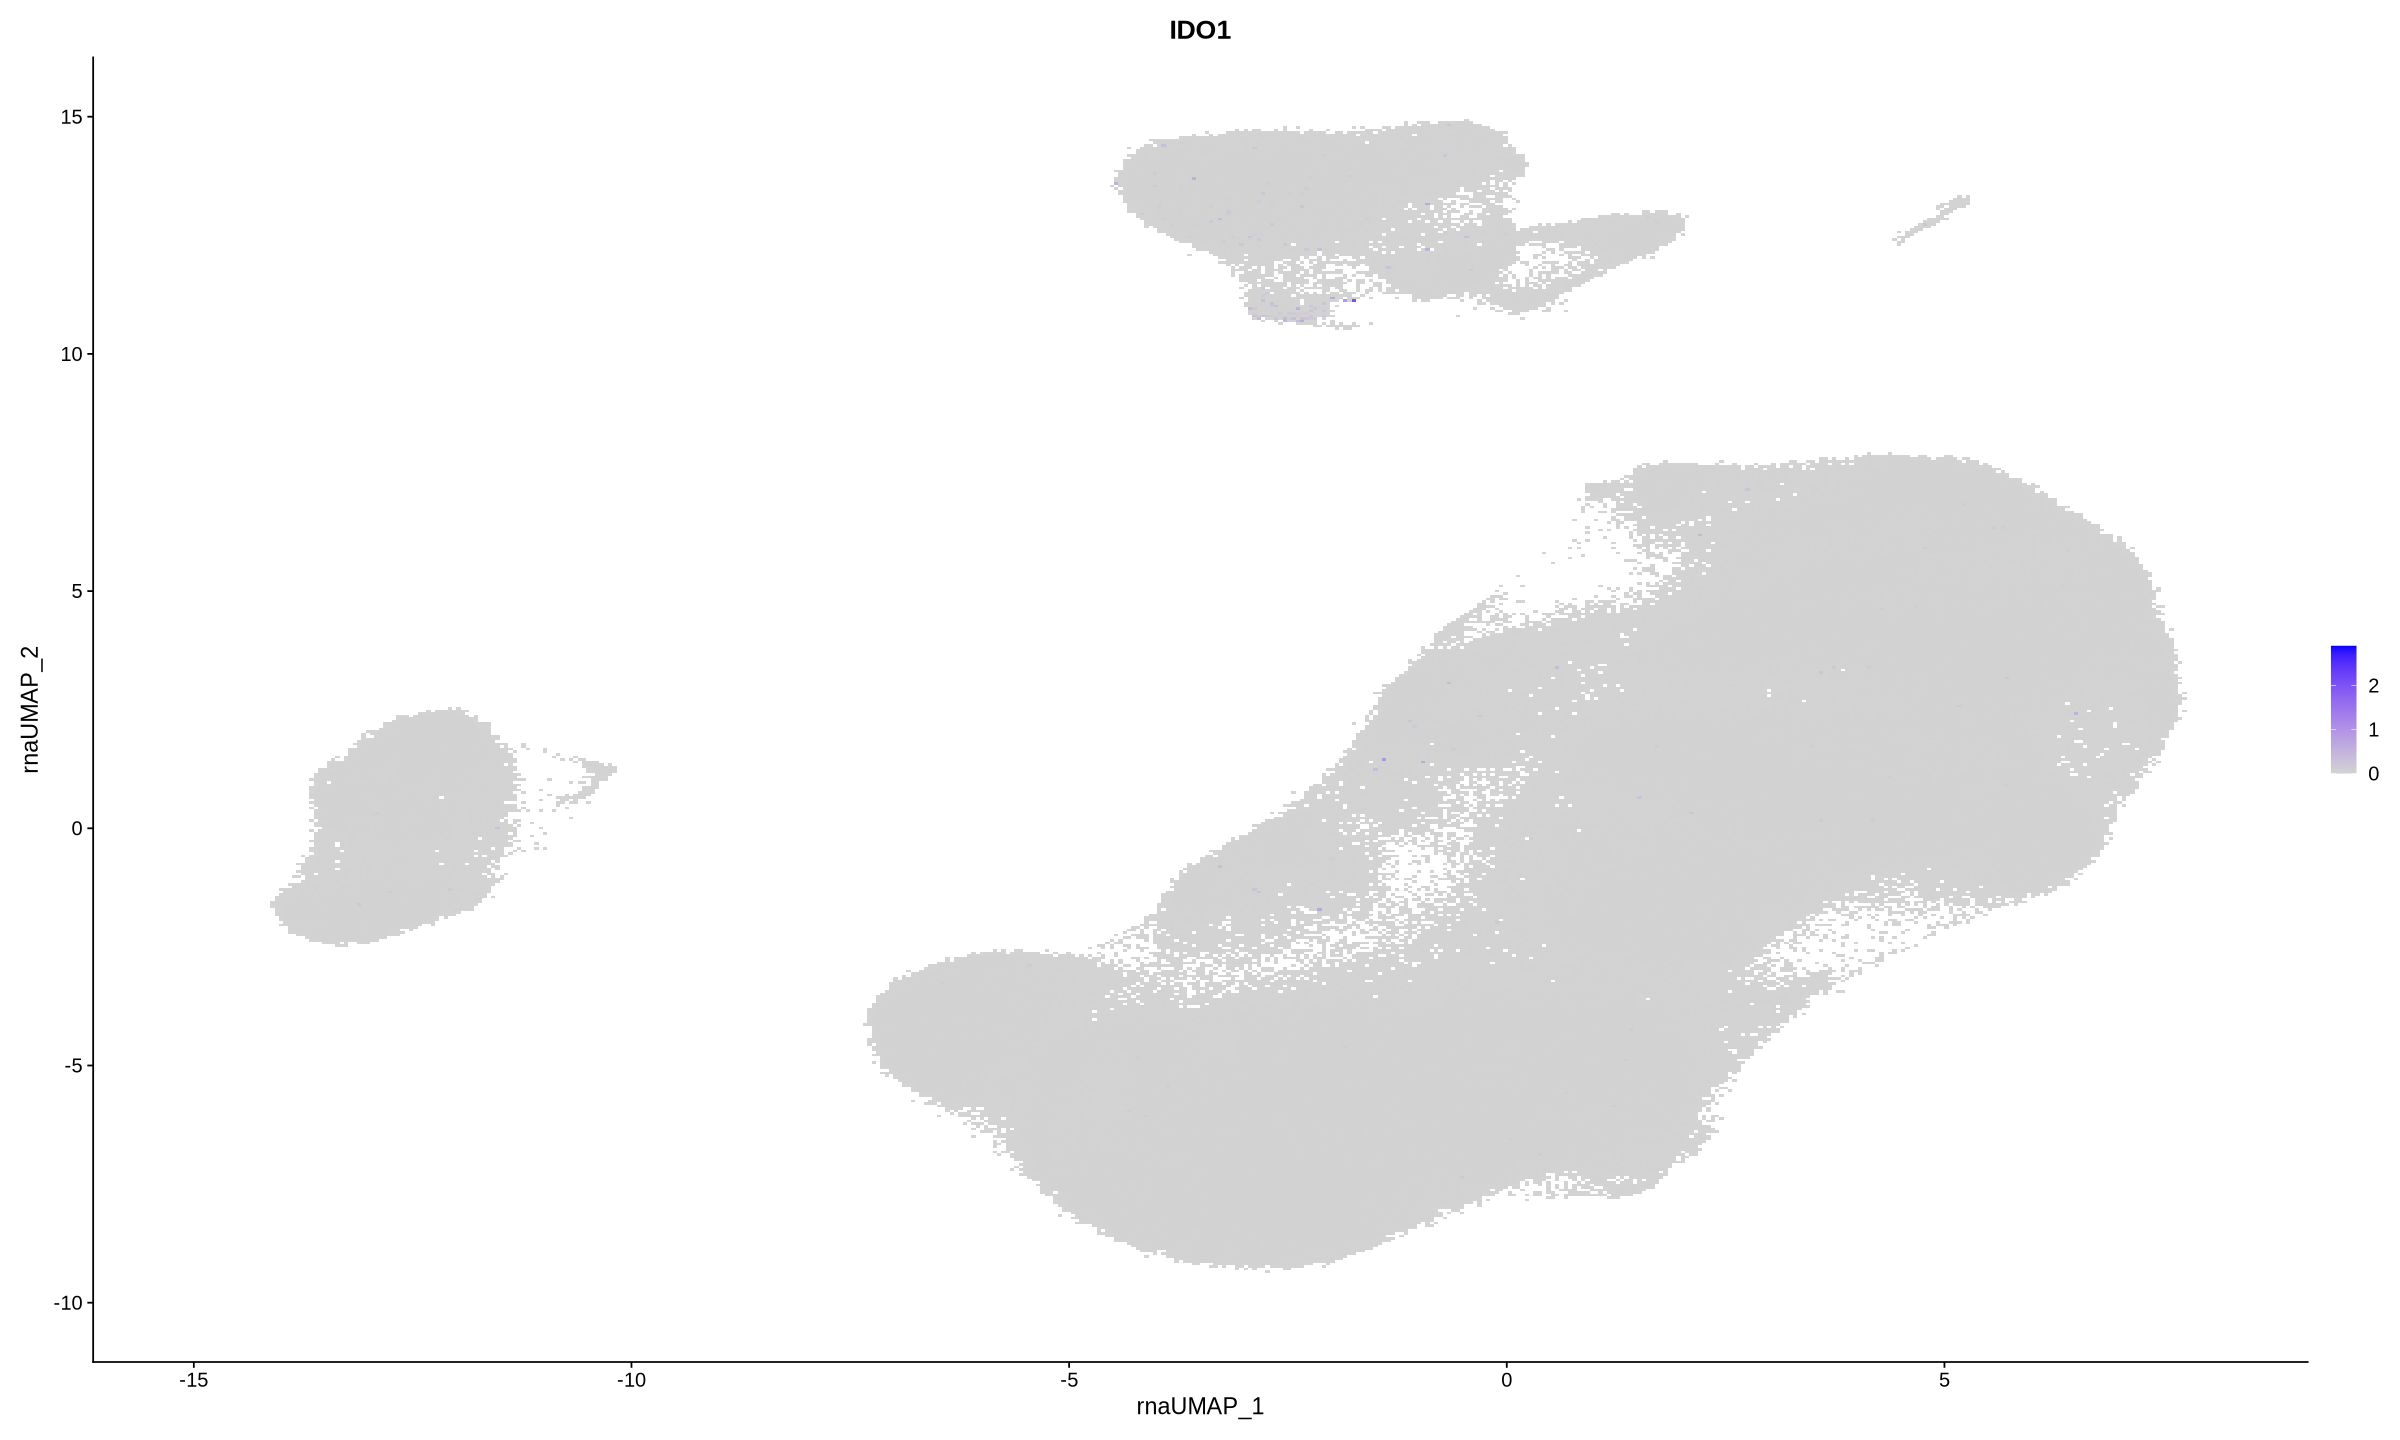

In [17]:
###### grep("IDO1", rownames(seur_obj), value = TRUE, ignore.case = TRUE)
FeaturePlot(seur_obj, features = "IDO1")

#DimPlot(seur_obj, reduction = 'adt.umap',   label = TRUE, repel = TRUE, label.size = 5.5) 

In [ ]:
DimPlot(nk_cells_repro, reduction = 'rna.umap',   label = TRUE, repel = TRUE, label.size = 5.5) 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



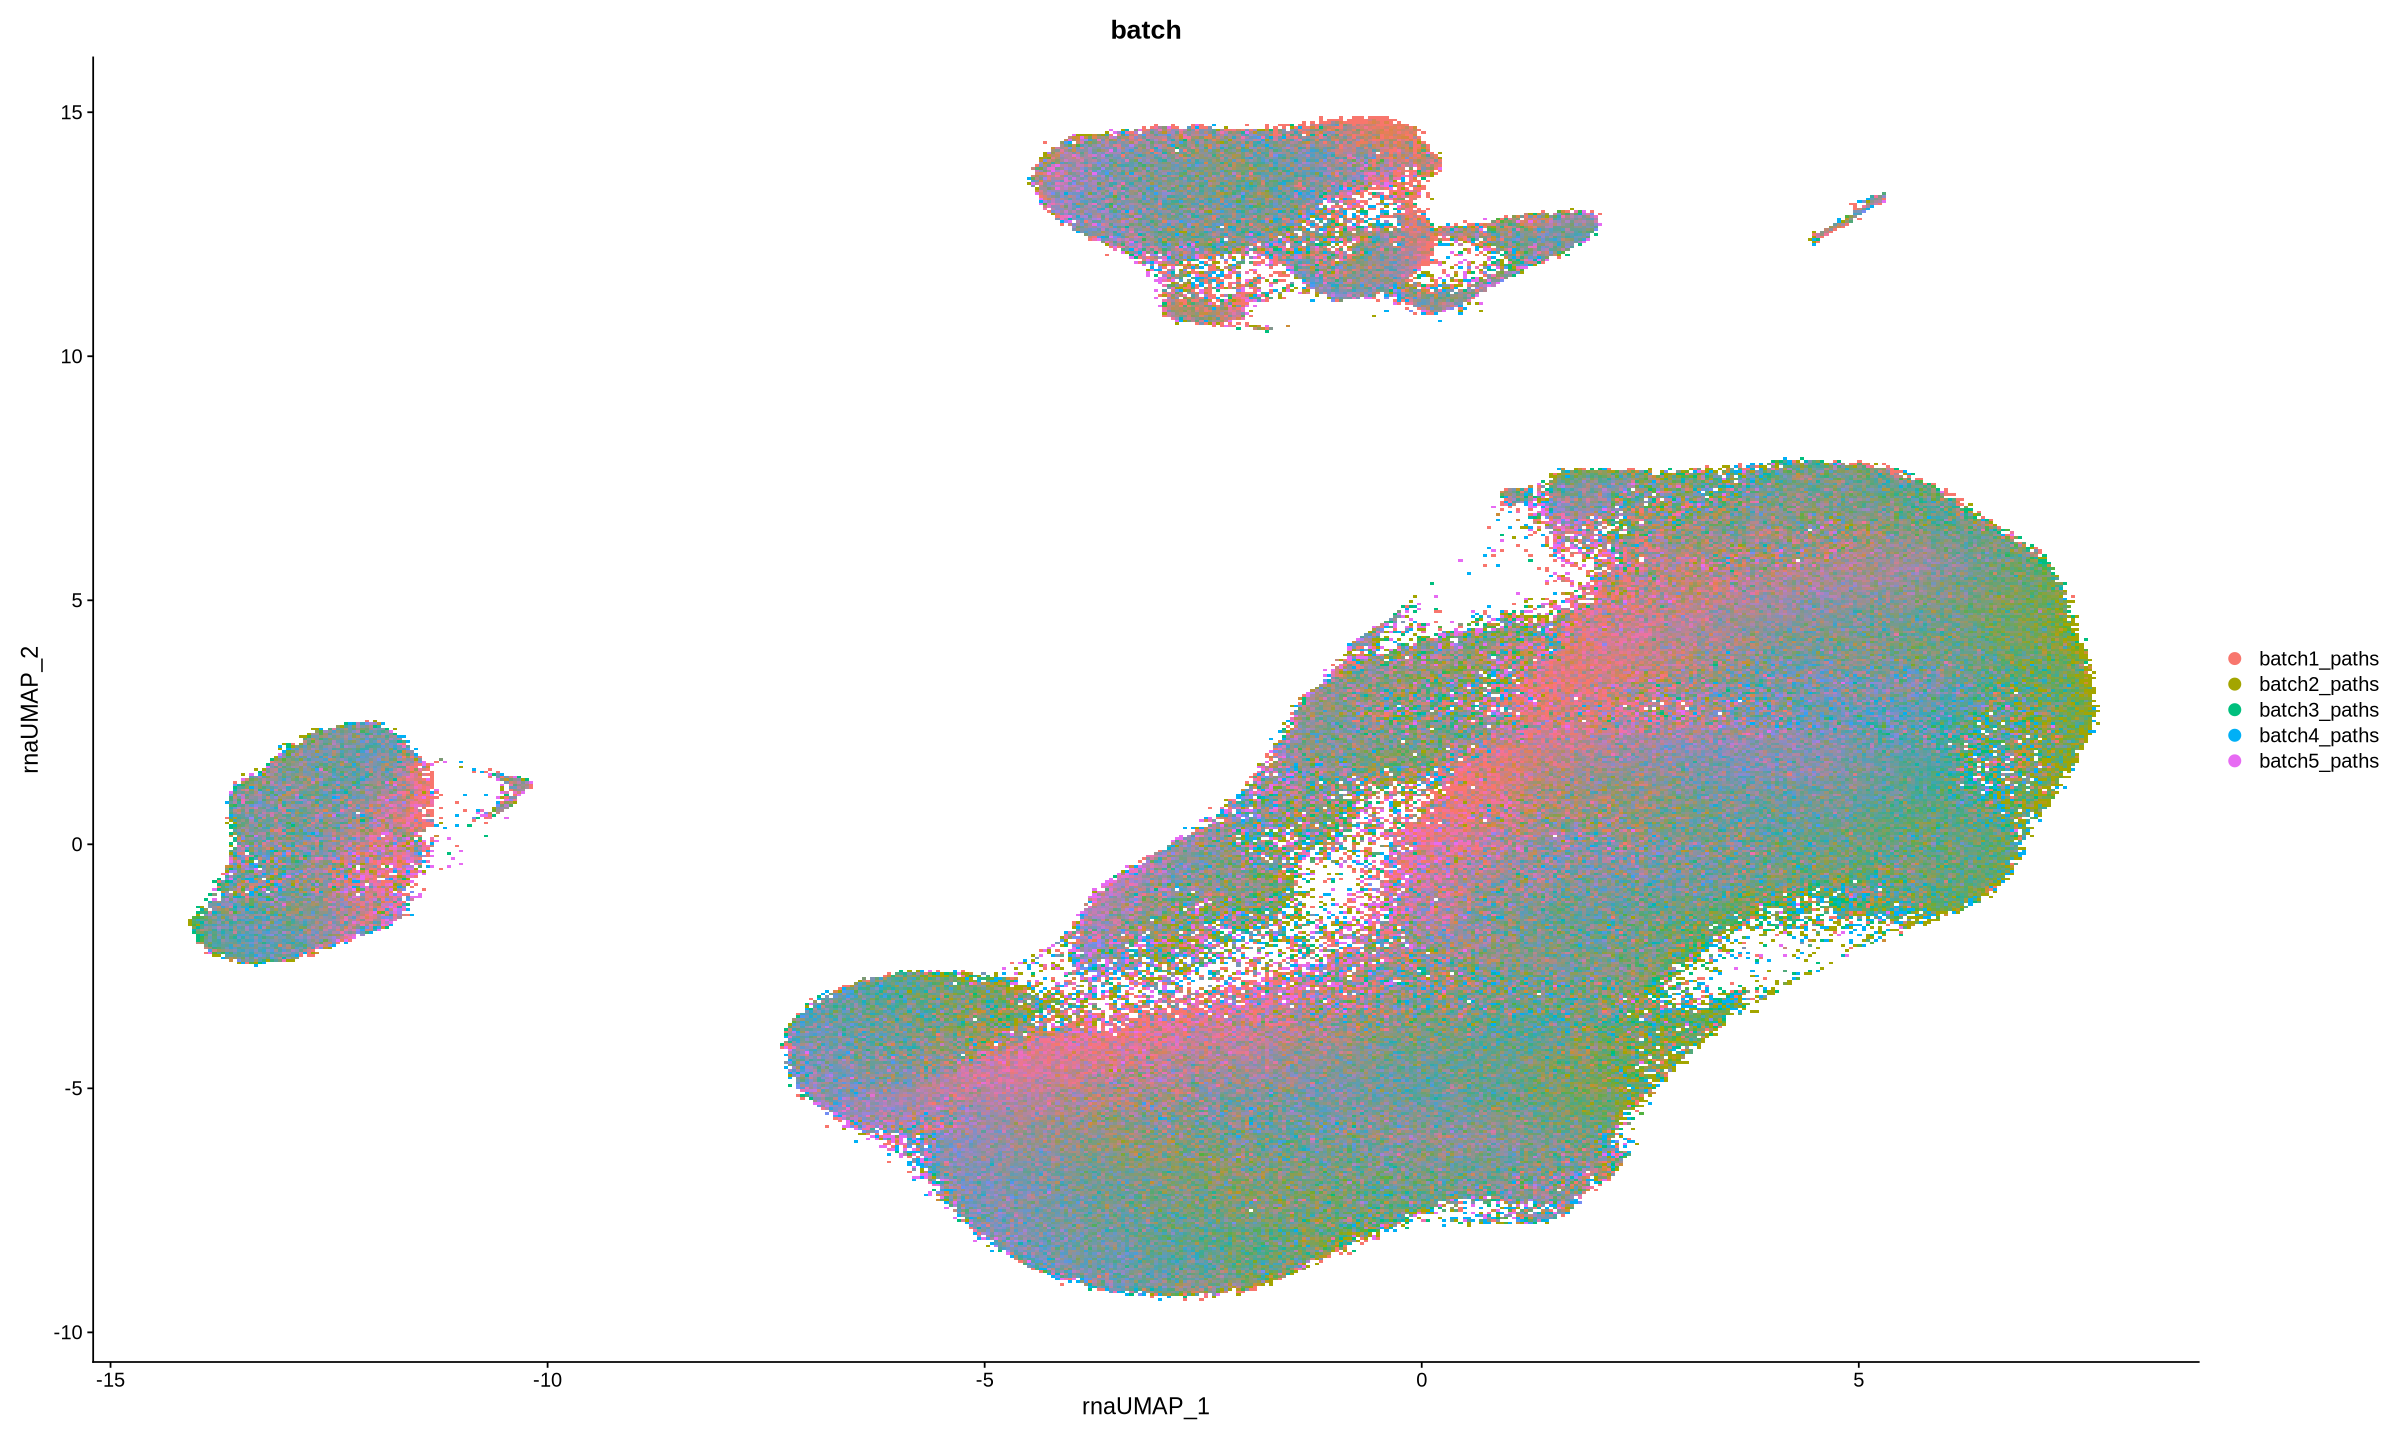

In [11]:
print(DimPlot(seur_obj, reduction = "rna.umap", group.by = "batch"))


In [9]:
print(table(seur_obj$batch, seur_obj$seurat_clusters))

              
                   0     1     2     3     4     5     6     7     8     9
  batch1_paths 16172  9956 10110  6373 10997  8825  8569  6239  8025  9745
  batch2_paths 16755 15883 15281  8888  6153  6159  4936  5277  4565  3503
  batch3_paths  6632  8296  8243  7633  3259  4366  2009  2630  2350  1298
  batch4_paths 19571 14929 15950 10114  8422  8164  6643  7112  7126  3087
  batch5_paths 14636 12823  7705  6308  5647  5891  7223  5591  4587  4727
              
                  10    11    12    13    14    15    16    17    18    19
  batch1_paths  4615  3055  3930  1834  2347  1831   887  2219  1370   691
  batch2_paths  5017  4780  3277  2865  1974  2030  3657   685   923  1672
  batch3_paths  3273  2914  2051  1273  1353   917   566   469   651   592
  batch4_paths  4318  3252  4124  2337  2964  1534  1653  1322  1138  1007
  batch5_paths  3571  4195  3920  3203  2309  1805   566   836   886   427
              
                  20    21    22    23    24
  batch1_p


    TRB:CASSLEASGYEQYF;TRA:CAVRAPHTGGFKTIF 
                                       211 
          TRB:CASSFNTNTDTQYF;TRA:CACGSRLTF 
                                       207 
                        TRB:CASSQDGFSNEQFF 
                                       186 
                         TRB:CSALRLEAYEQYF 
                                       168 
TRB:CASSIAPSSYNEQFF;TRA:CAVRVGDAGGTSYGKLTF 
                                       163 
                          TRB:CASSWVGYEQYF 
                                       160 
      TRB:CASREPGAKNIQYF;TRA:CVVSARGYQKVTF 
                                       154 
      TRB:CASRQRRLIYGYTF;TRA:CASKETSGSRLTF 
                                       143 
  TRB:CATNGIDGTYNEQFF;TRA:CVVNPAGGTSYGKLTF 
                                       139 
                        TRB:CASLPHRGRYEQYF 
                                       137 


                        IGL:CQVWDSSSDPPYVF 
                                       271 
                           IGL:CQSYDSSPWVF 
                                        83 
     IGH:CARAGHDDHPFDLW;IGL:CLSRDNIDTPSVVF 
                                        76 
IGH:CAKDARDDFGNYVGYADSW;IGL:CQTWTAAGAVRVFF 
                                        74 
     IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF 
                                        68 
                          IGL:CFSYTSSNIWVF 
                                        63 
          IGH:CAREYYYSFPEW;IGK:CQQLNSYPISF 
                                        54 
      IGH:CAGVSRSVGAGVFDNW;IGK:CQQNDTMPYTF 
                                        47 
                        IGL:CQTWTAAGAVRVFF 
                                        47 
                            IGK:CQQYNVWLTF 
                                        46 

[1] 1354

[1] 10

[1] 42

[1] 10

 [1] "IGL:CQVWDSSSDPPYVF"                        
 [2] "IGL:CQSYDSSPWVF"                           
 [3] "IGH:CARAGHDDHPFDLW;IGL:CLSRDNIDTPSVVF"     
 [4] "IGH:CAKDARDDFGNYVGYADSW;IGL:CQTWTAAGAVRVFF"
 [5] "IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF"     
 [6] "IGL:CFSYTSSNIWVF"                          
 [7] "IGH:CAREYYYSFPEW;IGK:CQQLNSYPISF"          
 [8] "IGH:CAGVSRSVGAGVFDNW;IGK:CQQNDTMPYTF"      
 [9] "IGL:CQTWTAAGAVRVFF"                        
[10] "IGK:CQQYNVWLTF"                            
 [1] "TRB:CASSLEASGYEQYF;TRA:CAVRAPHTGGFKTIF"    
 [2] "TRB:CASSFNTNTDTQYF;TRA:CACGSRLTF"          
 [3] "TRB:CASSQDGFSNEQFF"                        
 [4] "TRB:CSALRLEAYEQYF"                         
 [5] "TRB:CASSIAPSSYNEQFF;TRA:CAVRVGDAGGTSYGKLTF"
 [6] "TRB:CASSWVGYEQYF"                          
 [7] "TRB:CASREPGAKNIQYF;TRA:CVVSARGYQKVTF"      
 [8] "TRB:CASRQRRLIYGYTF;TRA:CASKETSGSRLTF"      
 [9] "TRB:CATNGIDGTYNEQFF;TRA:CVVNPAGGTSYGKLTF"  
[10] "TRB:CASLPHRGRYEQYF"                        


`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


cell_type,clonotype,frequency
<chr>,<chr>,<int>
CD8+ NKT-like cells,TRB:CASLPHRGRYEQYF,1
CD8+ NKT-like cells,TRB:CASSFNTNTDTQYF;TRA:CACGSRLTF,6
CD8+ NKT-like cells,TRB:CASSWVGYEQYF,1
Classical Monocytes,TRB:CASREPGAKNIQYF;TRA:CVVSARGYQKVTF,1
Classical Monocytes,TRB:CASSIAPSSYNEQFF;TRA:CAVRVGDAGGTSYGKLTF,1
Classical Monocytes,TRB:CASSQDGFSNEQFF,1


`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


gene,clonotype,frequency
<chr>,<chr>,<int>
TRAV10,TRB:CASREPGAKNIQYF;TRA:CVVSARGYQKVTF,74
TRAV12-1,TRB:CATNGIDGTYNEQFF;TRA:CVVNPAGGTSYGKLTF,24
TRAV17,TRB:CASRQRRLIYGYTF;TRA:CASKETSGSRLTF,50
TRAV3,TRB:CASSLEASGYEQYF;TRA:CAVRAPHTGGFKTIF,87
TRAV38-2/DV8,TRB:CASSFNTNTDTQYF;TRA:CACGSRLTF,71
TRAV41,TRB:CASSIAPSSYNEQFF;TRA:CAVRVGDAGGTSYGKLTF,67


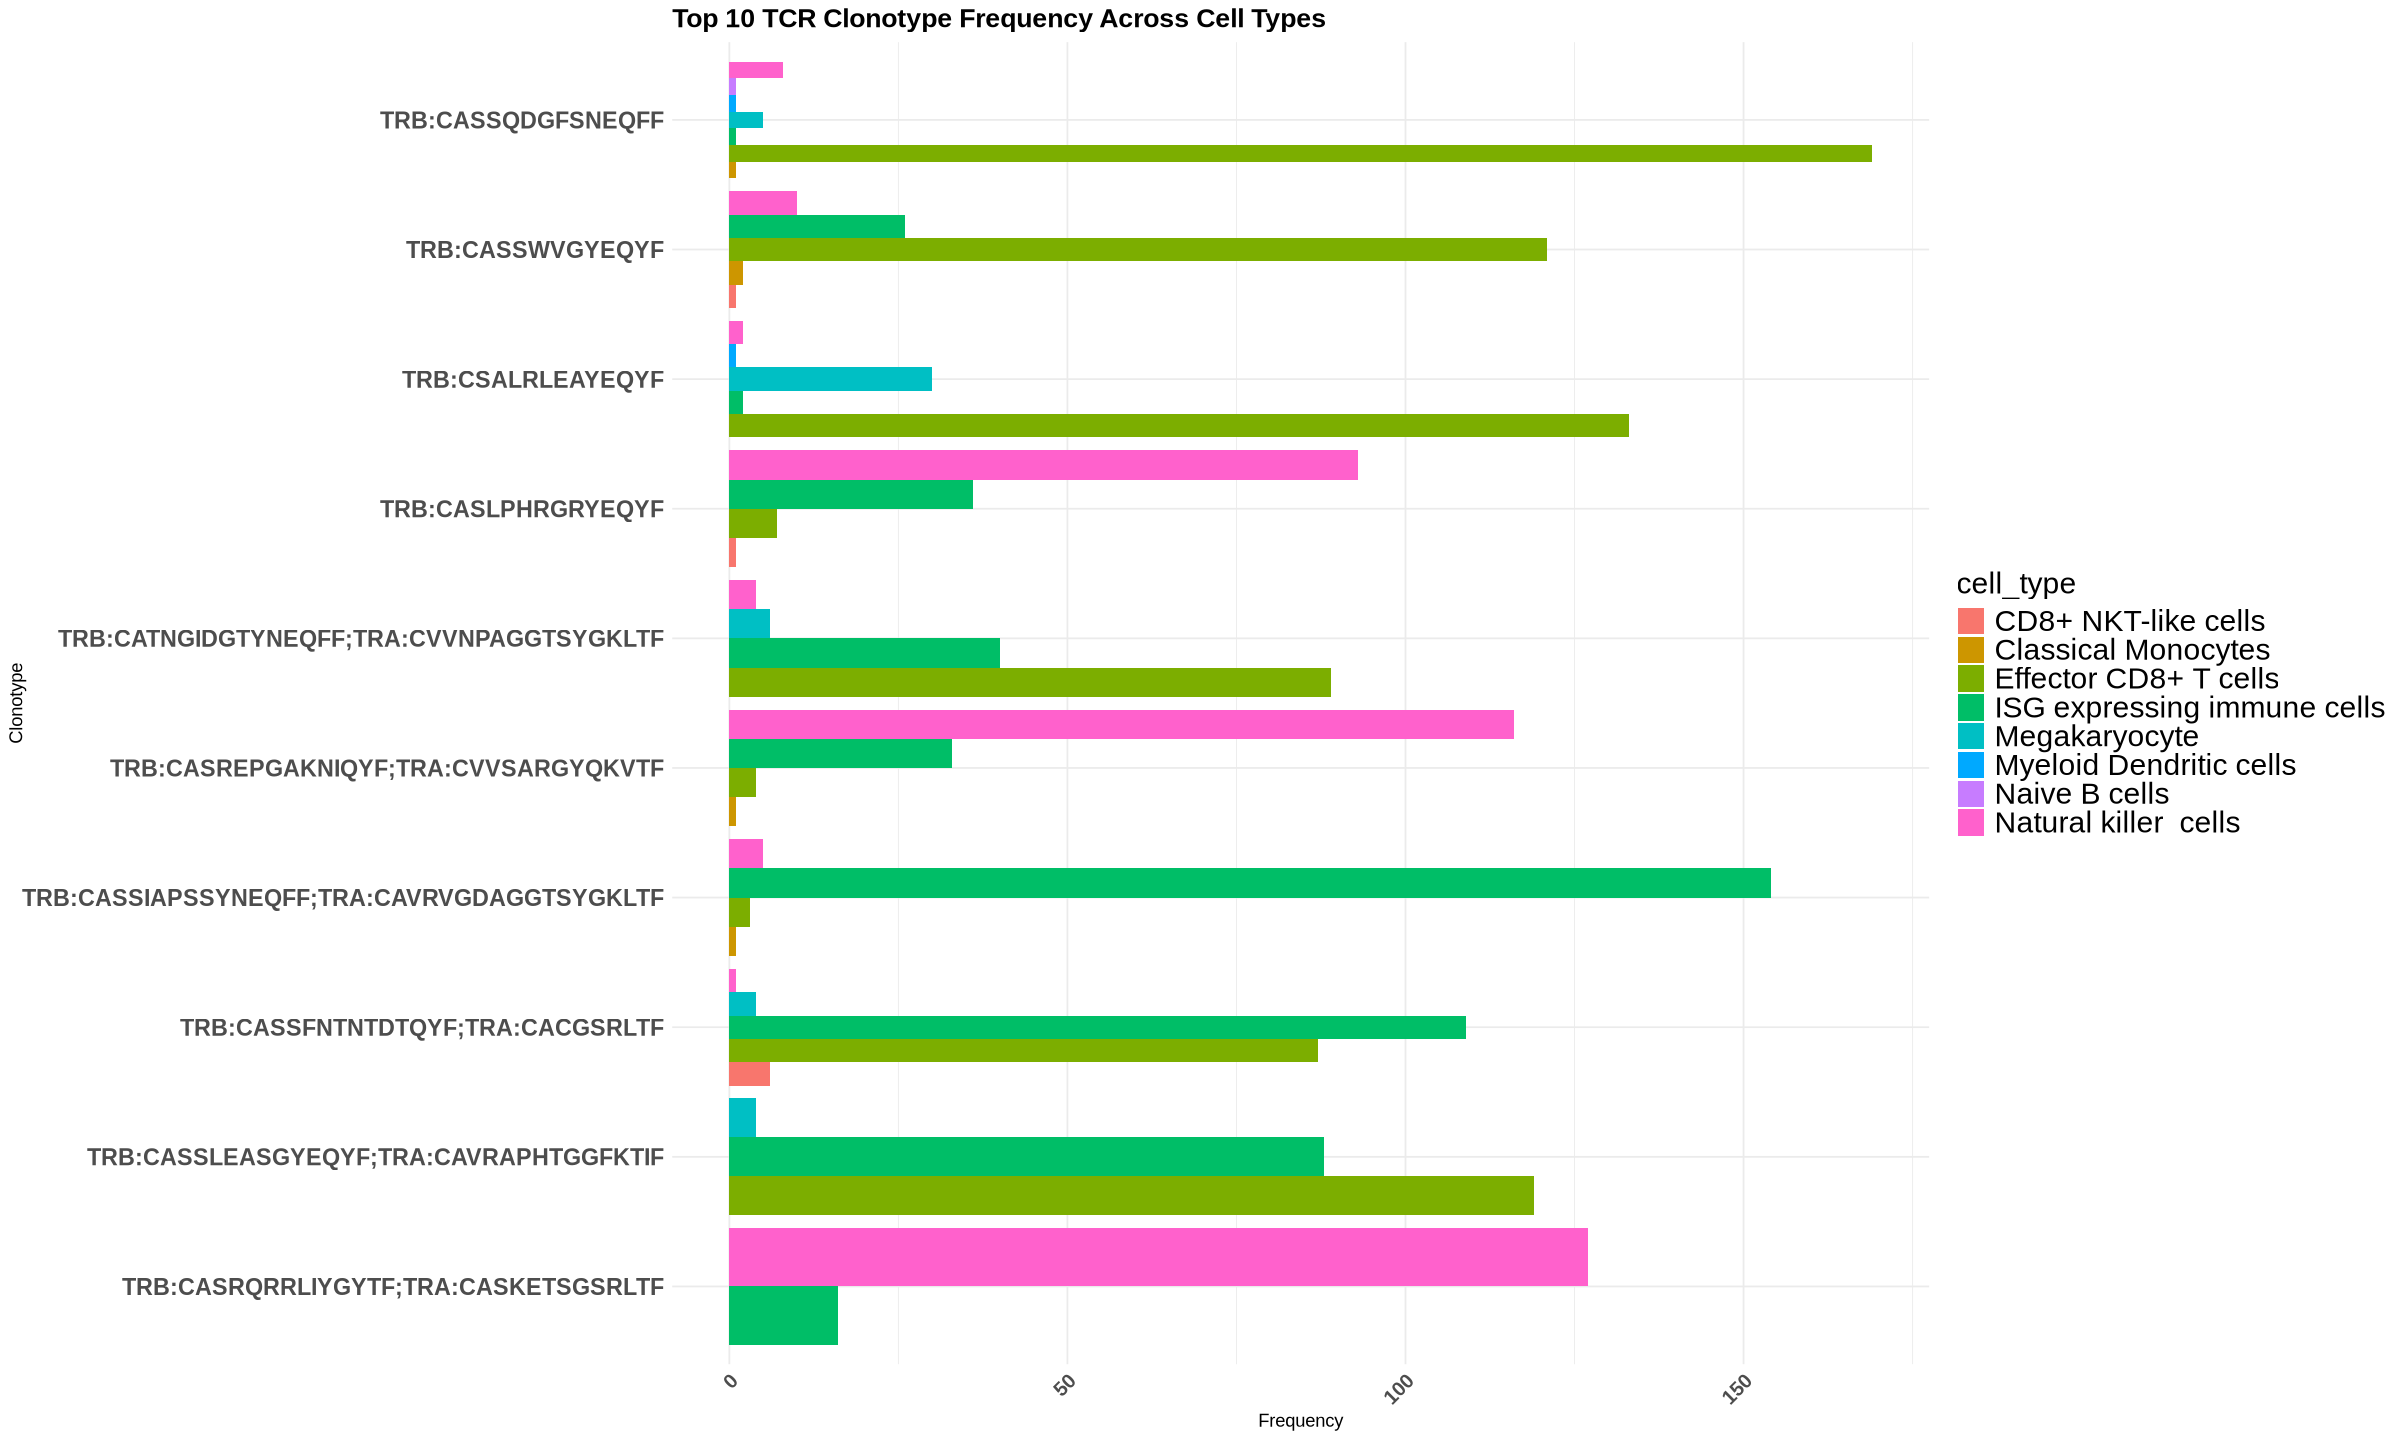

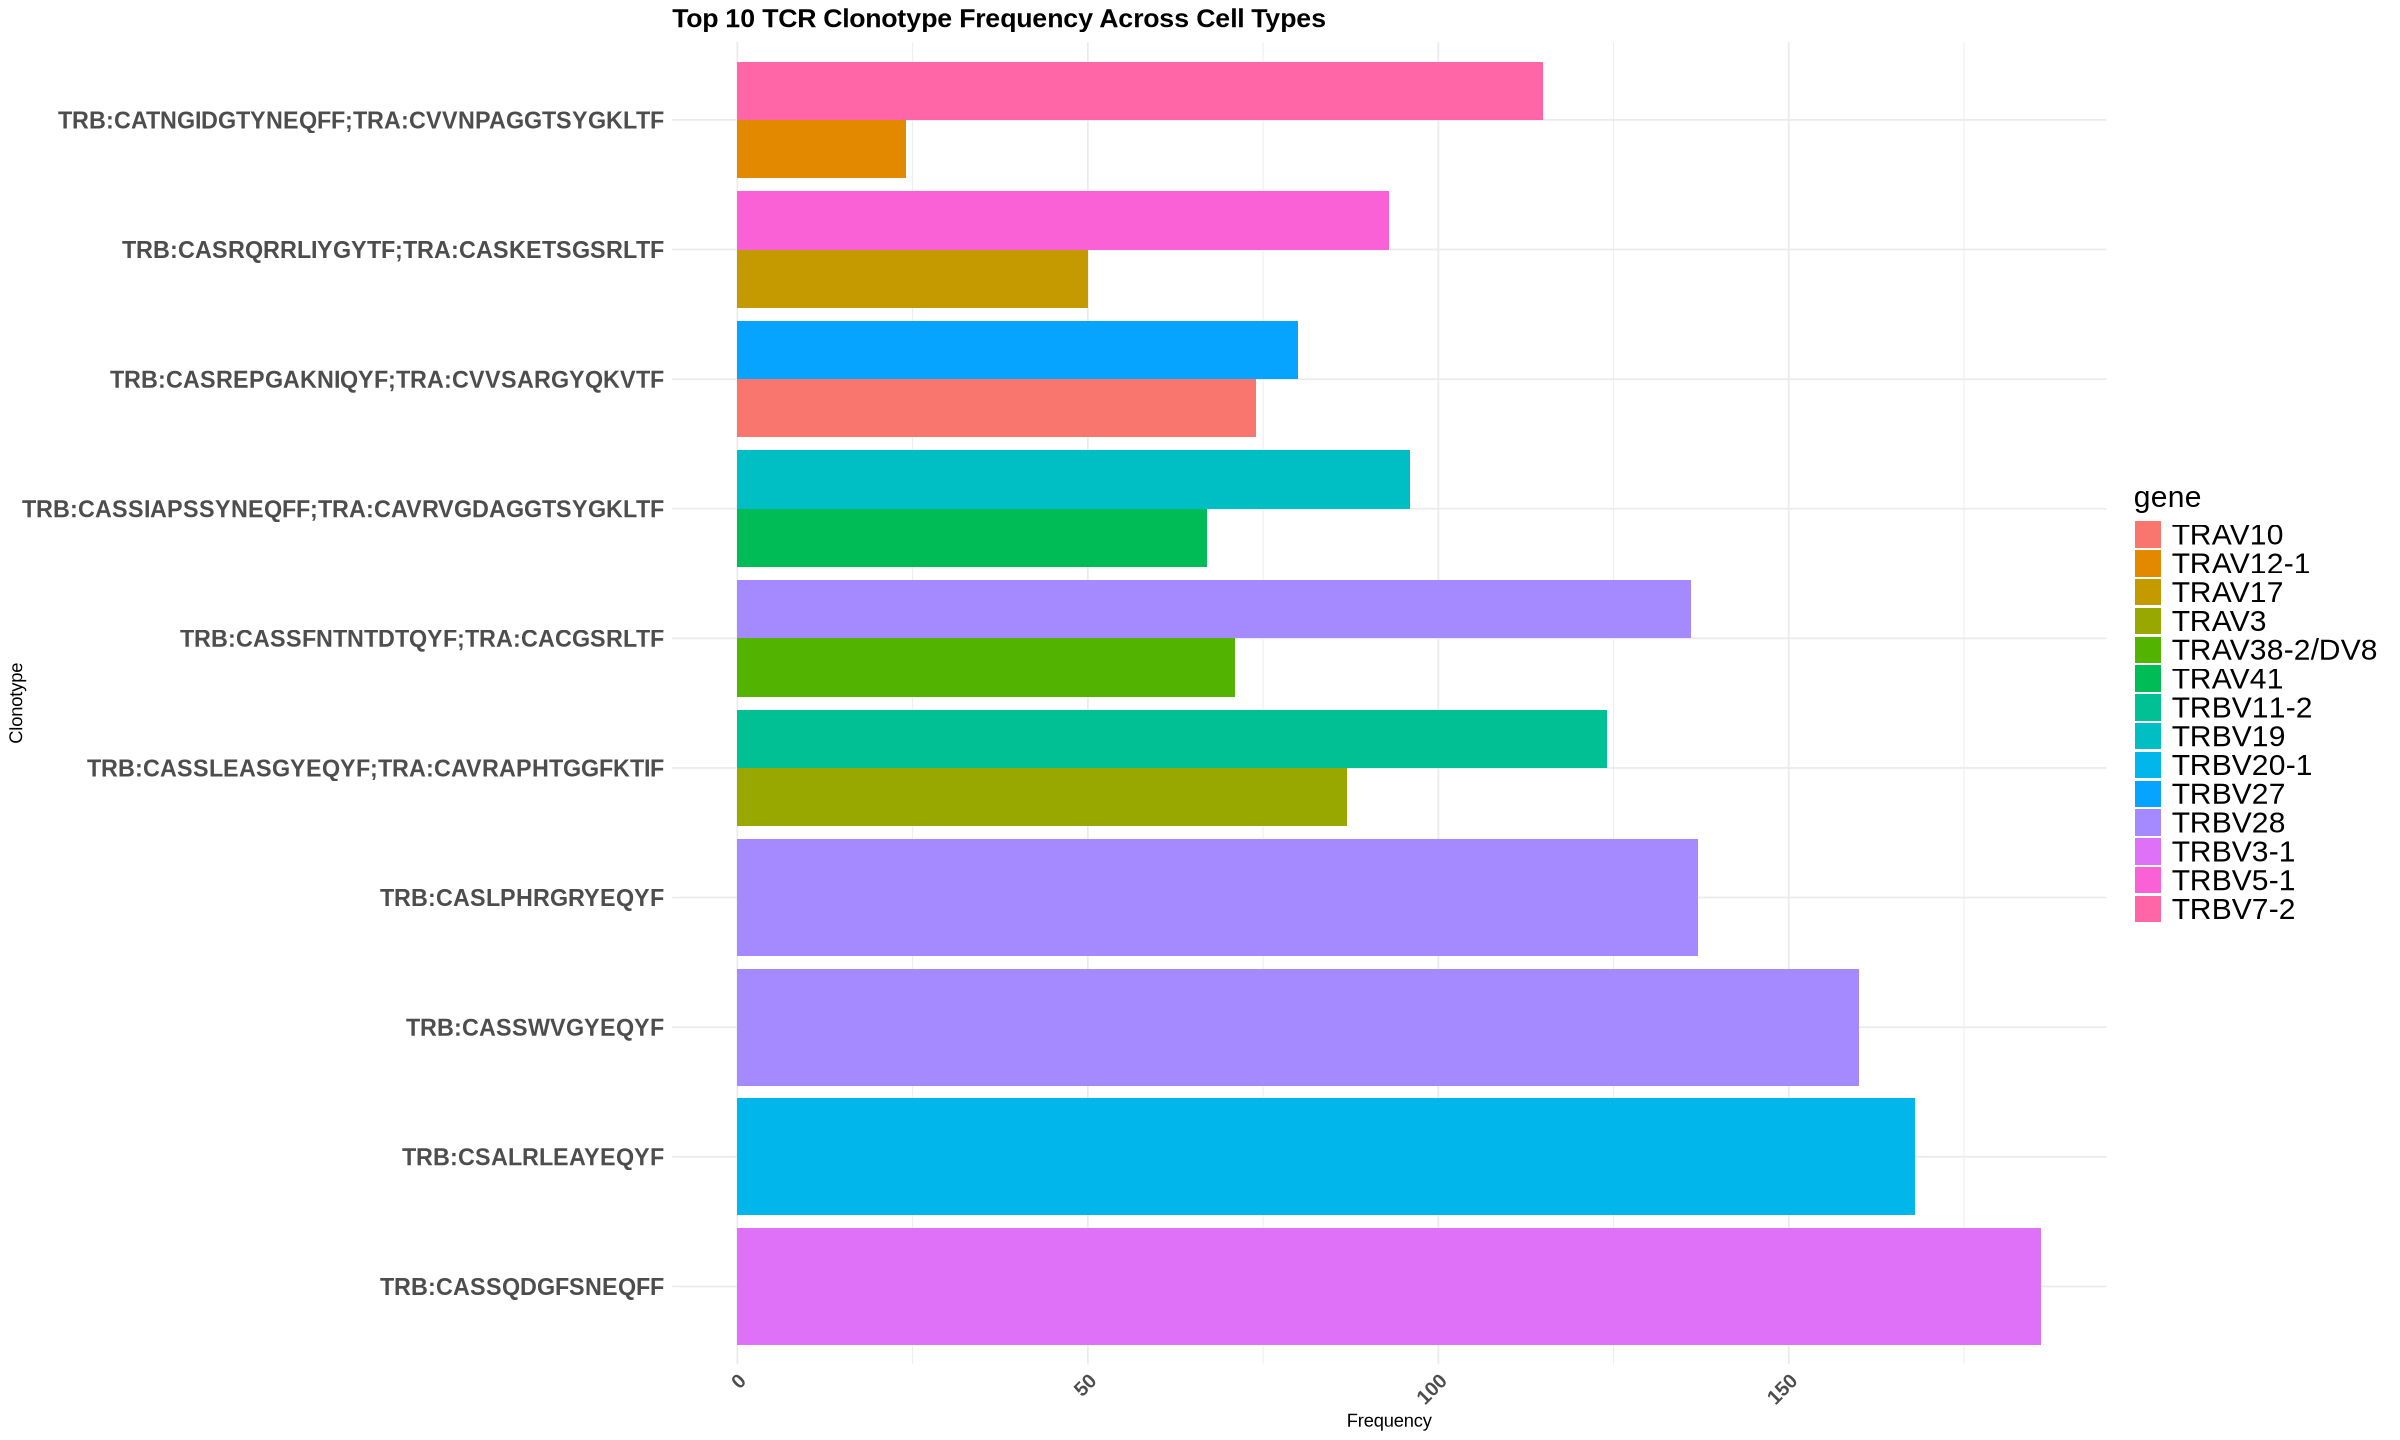

In [15]:
# TCR clonotype frequency
tcr_freq <- table(seur_obj$t_cdr3s_aa)
#tcr_freq <- table(seur_obj$t_v_gene)
# Display the top 10 clonotypes by frequency

head(sort(tcr_freq, decreasing = TRUE), 10)

# BCR clonotype frequency
bcr_freq <- table(seur_obj$b_cdr3s_aa)
#bcr_freq <- table(seur_obj$b_v_gene)

# Display the top 10 clonotypes by frequency
head(sort(bcr_freq, decreasing = TRUE), 10)

# Identify expanded TCR clonotypes (appears in 10 or more cells)
expanded_tcr <- tcr_freq[tcr_freq >= 10]

# Get the top 10 expanded TCR clonotypes by frequency
top_10_expanded_tcr <- head(sort(expanded_tcr, decreasing = TRUE), 10)
# Display expanded TCR clonotypes
length(expanded_tcr)
length(top_10_expanded_tcr)
# Identify expanded BCR clonotypes (appears in 10 or more cells)
expanded_bcr <- bcr_freq[bcr_freq >= 10]
top_10_expanded_bcr <- head(sort(expanded_bcr, decreasing = TRUE), 10)
# Display expanded TCR clonotypes
length(expanded_bcr)
length(top_10_expanded_bcr)
                     
top_10_tcr_clonotypes = names(top_10_expanded_tcr)
top_10_bcr_clonotypes = names(top_10_expanded_bcr)  
                     
print(top_10_bcr_clonotypes)
print(top_10_tcr_clonotypes)  

                     # Create a data frame combining clonotype and cell type information
tcr_df <- data.frame(
  clonotype = seur_obj$t_cdr3s_aa,
  cell_type = seur_obj$sctype_classification
)
# Filter the data to include only the top 10 clonotypes
tcr_top_10_df <- tcr_df %>% filter(clonotype %in% top_10_tcr_clonotypes)

# Summarize clonotype frequencies by cell type for top 10 clonotypes
tcr_top_10_freq_by_celltype <- tcr_top_10_df %>%
  group_by(cell_type, clonotype) %>%
  summarise(frequency = n()) %>%
  ungroup()

# View the summarized data
head(tcr_top_10_freq_by_celltype)

print(ggplot(tcr_top_10_freq_by_celltype, aes(y = reorder(clonotype, -frequency), x = frequency, fill = cell_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Top 10 TCR Clonotype Frequency Across Cell Types", y = "Clonotype", x = "Frequency") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12, face = "bold", angle = 45, hjust = 1),  # Rotate x-axis labels by 45 degrees
    axis.text.y = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 18),  # Increase legend text size
    legend.title = element_text(size = 18)  # Increase legend title size
  ))

# Create a data frame combining clonotype and tcrgene info
tcr_df2 <- data.frame(
  clonotype = seur_obj$t_cdr3s_aa,
  gene = seur_obj$t_v_gene
)
# Filter the data to include only the top 10 clonotypes
tcr_top_10_df2 <- tcr_df2 %>% filter(clonotype %in% top_10_tcr_clonotypes)
 # Summarize clonotype frequencies by cell type for top 10 clonotypes
tcr_top_10_freq_by_gene <- tcr_top_10_df2 %>%
  group_by(gene, clonotype) %>%
  summarise(frequency = n()) %>%
  ungroup()

# View the summarized data
head(tcr_top_10_freq_by_gene)

print(ggplot(tcr_top_10_freq_by_gene, aes(y = reorder(clonotype, -frequency), x = frequency, fill = gene)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Top 10 TCR Clonotype Frequency Across Cell Types", y = "Clonotype", x = "Frequency") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12, face = "bold", angle = 45, hjust = 1),  # Rotate x-axis labels by 45 degrees
    axis.text.y = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 18),  # Increase legend text size
    legend.title = element_text(size = 18)))  # Increase legend title size

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


cell_type,clonotype,frequency
<chr>,<chr>,<int>
CD8+ NKT-like cells,IGH:CAKDARDDFGNYVGYADSW;IGL:CQTWTAAGAVRVFF,1
CD8+ NKT-like cells,IGH:CARAGHDDHPFDLW;IGL:CLSRDNIDTPSVVF,1
Classical Monocytes,IGH:CAGVSRSVGAGVFDNW;IGK:CQQNDTMPYTF,2
Classical Monocytes,IGH:CAKDARDDFGNYVGYADSW;IGL:CQTWTAAGAVRVFF,5
Classical Monocytes,IGH:CARAGHDDHPFDLW;IGL:CLSRDNIDTPSVVF,7
Classical Monocytes,IGH:CAREYYYSFPEW;IGK:CQQLNSYPISF,4


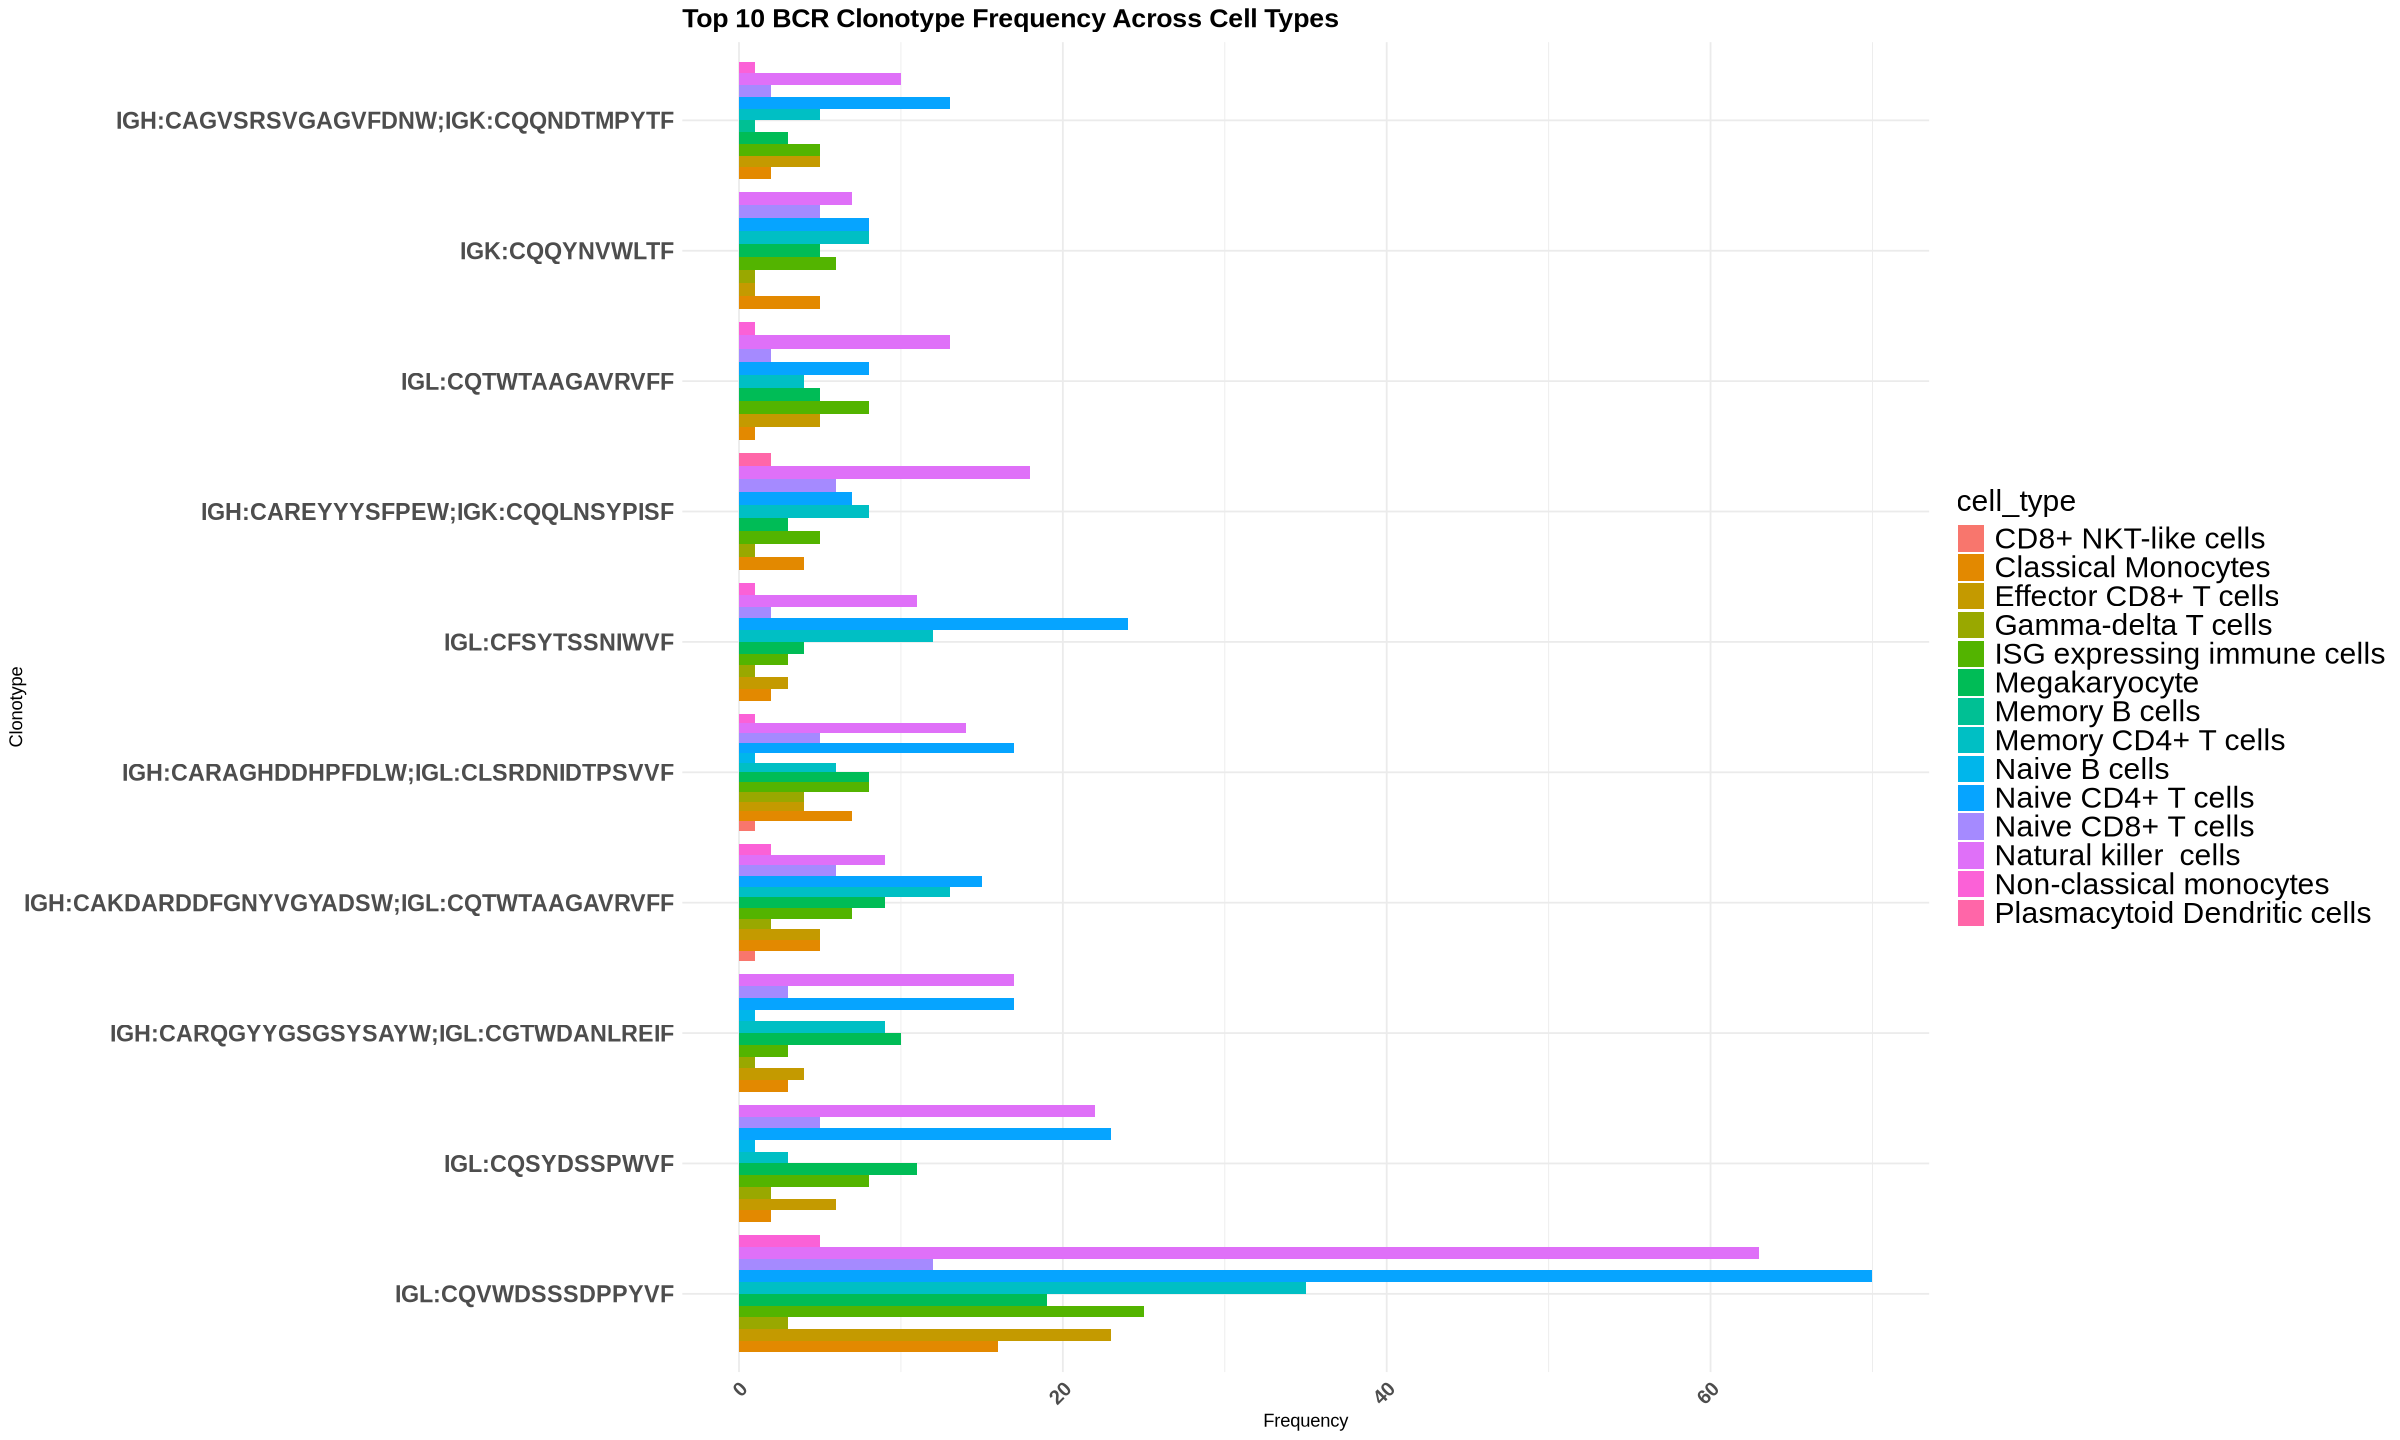

In [19]:
bcr_df <- data.frame(
  clonotype = seur_obj$b_cdr3s_aa,
  cell_type = seur_obj$sctype_classification
)
# Filter the data to include only the top 10 clonotypes
bcr_top_10_df <- bcr_df %>% filter(clonotype %in% top_10_bcr_clonotypes)

# Summarize clonotype frequencies by cell type for top 10 clonotypes
bcr_top_10_freq_by_celltype <- bcr_top_10_df %>%
  group_by(cell_type, clonotype) %>%
  summarise(frequency = n()) %>%
  ungroup()

# View the summarized data
head(bcr_top_10_freq_by_celltype)

print(ggplot(bcr_top_10_freq_by_celltype, aes(y = reorder(clonotype, -frequency), x = frequency, fill = cell_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Top 10 BCR Clonotype Frequency Across Cell Types", y = "Clonotype", x = "Frequency") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12, face = "bold", angle = 45, hjust = 1),  # Rotate x-axis labels by 45 degrees
    axis.text.y = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 18),  # Increase legend text size
    legend.title = element_text(size = 18)  # Increase legend title size
  ))


,clonotype,gene
,<chr>,<chr>
AAACCTGGTCATGCAT-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGHV1-2
AACCATGCAGTGACAG-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51
AACTGGTCAGGTCCAC-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51
AAGGAGCGTCATATCG-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51
ACACCCTCAGTCAGCC-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51
ACCTTTAAGATCCCAT-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51
ACGGCCAGTTTGTGTG-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGHV1-2
AGAGCGAGTGTTAAGA-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51
AGAGCTTAGATCGGGT-1_2_1_1_1,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,IGLV1-51


`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


gene,clonotype,frequency
<chr>,<chr>,<int>
IGHV1-2,IGH:CARQGYYGSGSYSAYW;IGL:CGTWDANLREIF,33
IGHV1-46,IGH:CAGVSRSVGAGVFDNW;IGK:CQQNDTMPYTF,25
IGHV1-8,IGH:CARAGHDDHPFDLW;IGL:CLSRDNIDTPSVVF,58
IGHV3-11,IGH:CAREYYYSFPEW;IGK:CQQLNSYPISF,31
IGHV3-43,IGH:CAKDARDDFGNYVGYADSW;IGL:CQTWTAAGAVRVFF,33
IGKV1-39,IGH:CAGVSRSVGAGVFDNW;IGK:CQQNDTMPYTF,22


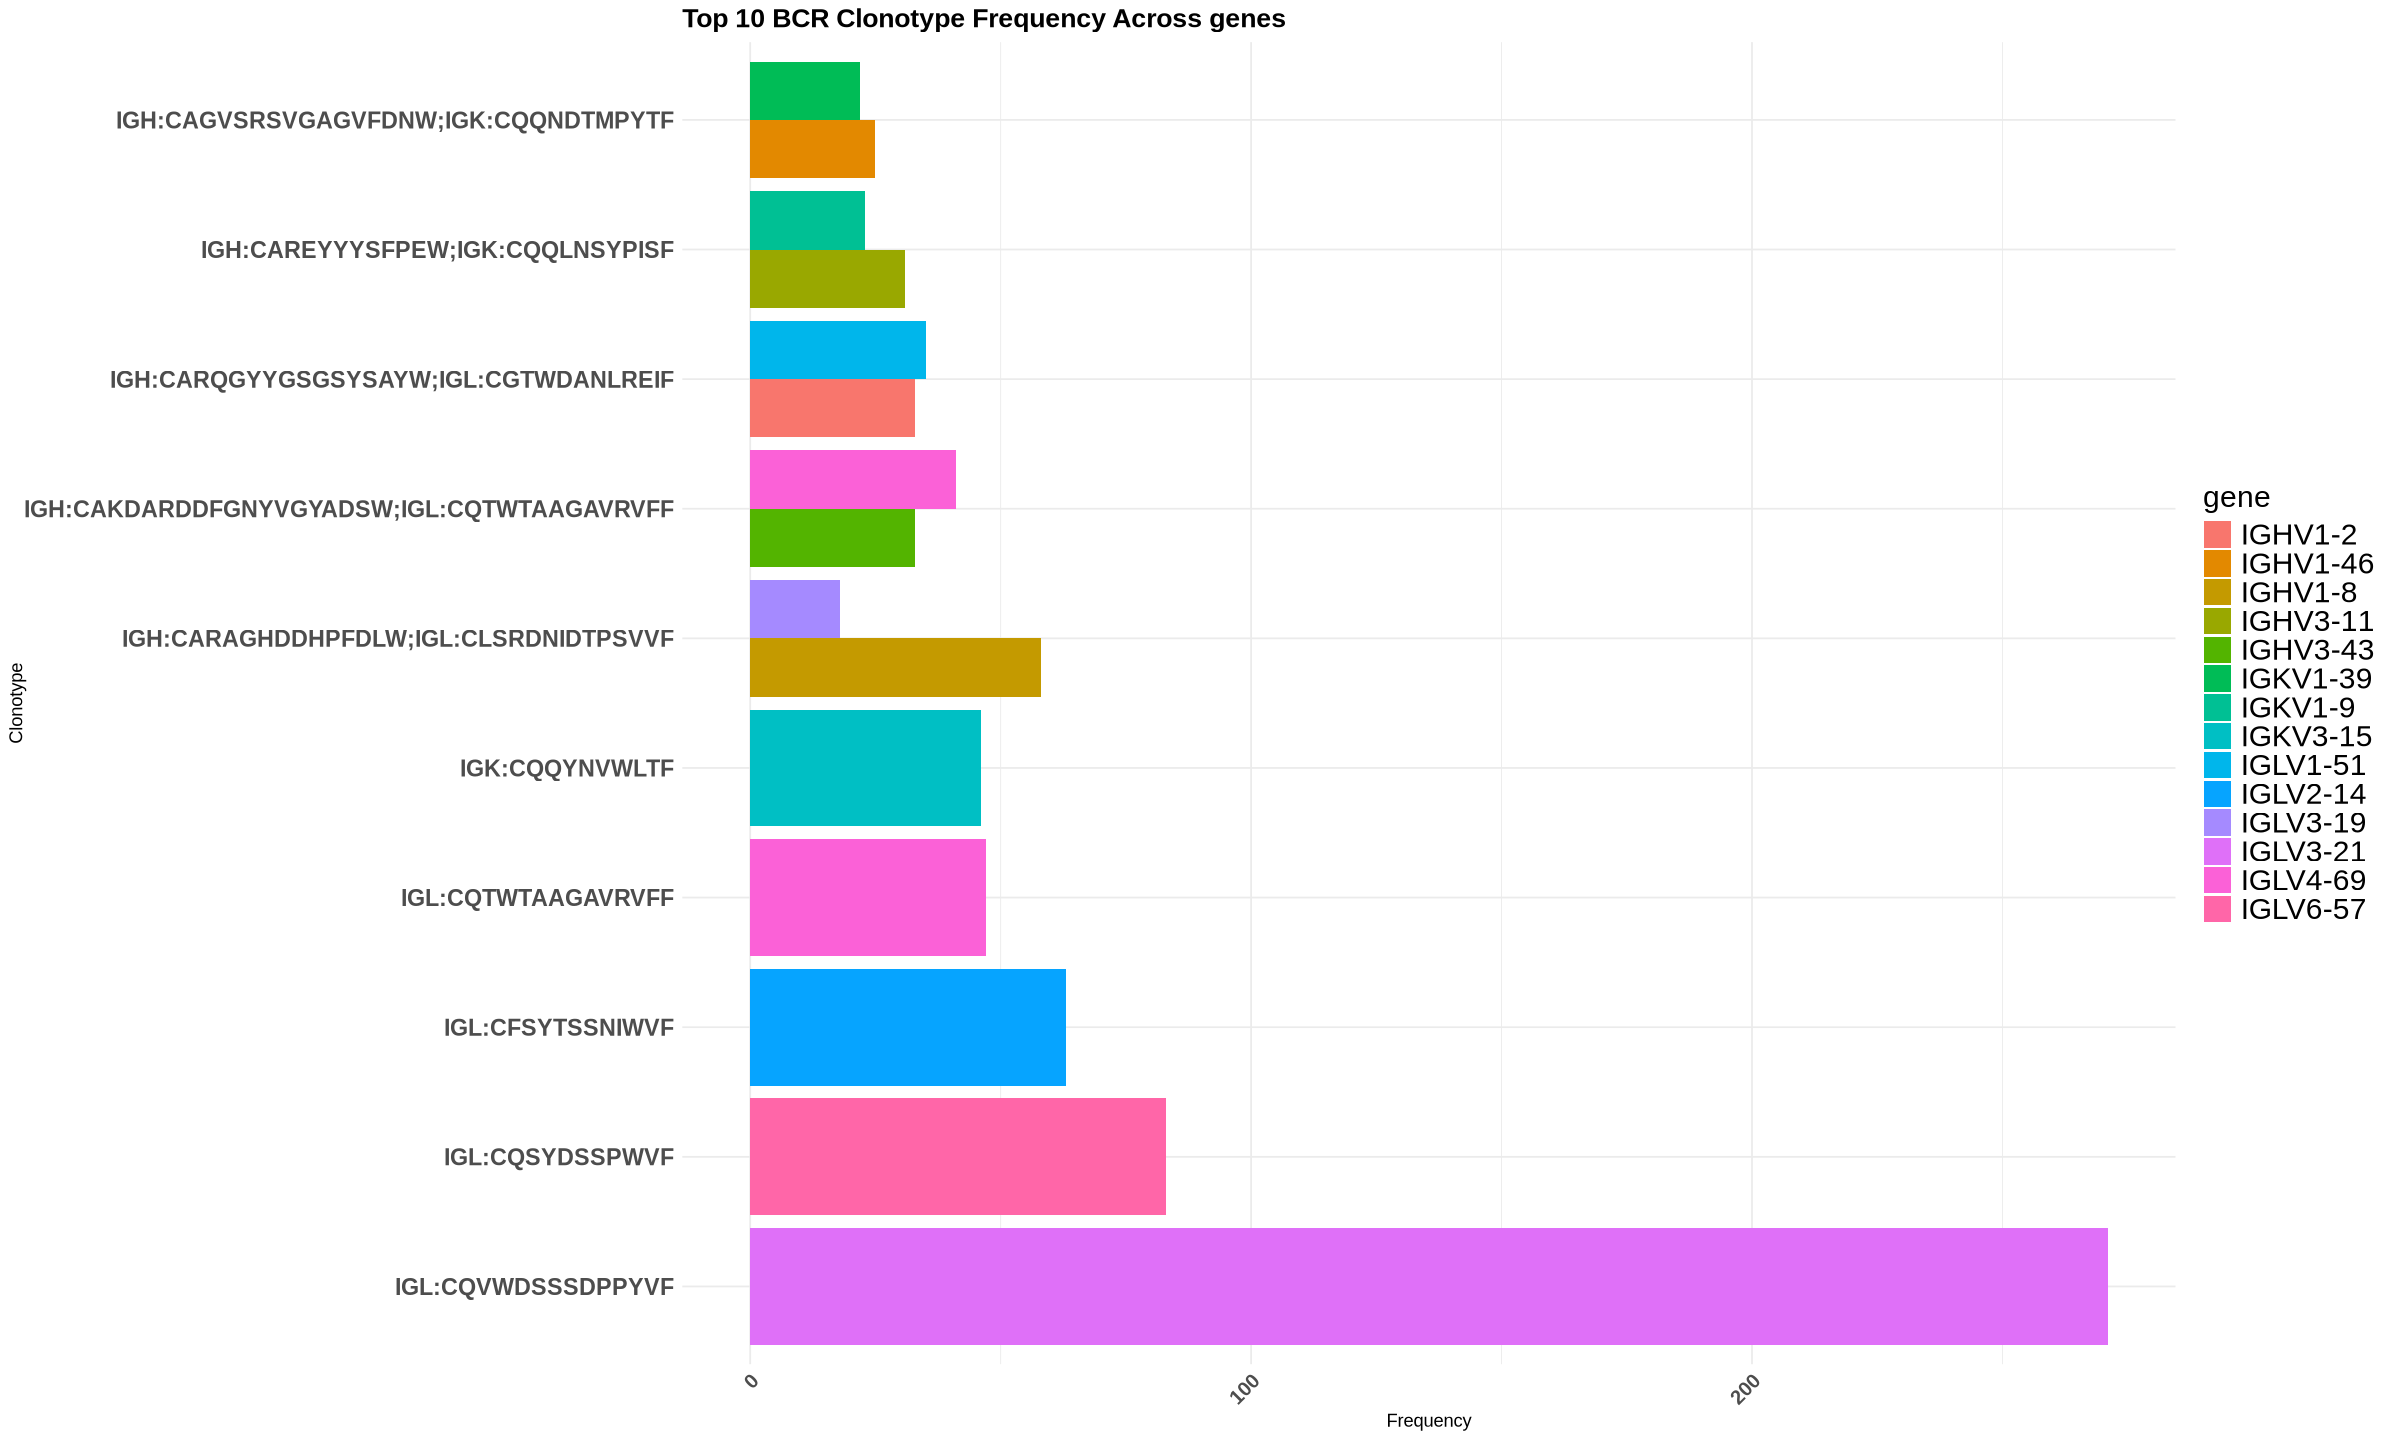

In [17]:
# Create a data frame combining clonotype and bcrgene info
bcr_df2 <- data.frame(
  clonotype = seur_obj$b_cdr3s_aa,
  gene = seur_obj$b_v_gene
)

# Filter the data to include only the top 10 clonotypes
bcr_top_10_df2 <- bcr_df2 %>% filter(clonotype %in% top_10_bcr_clonotypes)
bcr_top_10_df2 
# Summarize clonotype frequencies by cell type for top 10 clonotypes
bcr_top_10_freq_by_gene <- bcr_top_10_df2 %>%
  group_by(gene, clonotype) %>%
  summarise(frequency = n()) %>%
  ungroup()

# View the summarized data
head(bcr_top_10_freq_by_gene)

print(ggplot(bcr_top_10_freq_by_gene, aes(y = reorder(clonotype, -frequency), x = frequency, fill = gene)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Top 10 BCR Clonotype Frequency Across genes", y = "Clonotype", x = "Frequency") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 12, face = "bold", angle = 45, hjust = 1),  # Rotate x-axis labels by 45 degrees
    axis.text.y = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 18),  # Increase legend text size
    legend.title = element_text(size = 18)))  # Increase legend title size
                     

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 12)

RNAUMAP = DimPlot(seur_obj, reduction = "rna.umap", label = TRUE, repel = TRUE, group.by = 'sctype_classification',label.size = 5) + 
  NoLegend()   

p1 = FeaturePlot(seur_obj, features = c("PF4"), reduction = 'rna.umap' )  #PF4, SDPR, GNG11, PPBP.
p2 = FeaturePlot(seur_obj, features = c("GNG11"), reduction = 'rna.umap' )  #PF4, SDPR, GNG11, PPBP.
p3 = FeaturePlot(seur_obj, features = c("PPBP"), reduction = 'rna.umap' )  #PF4, SDPR, GNG11, PPBP.

(RNAUMAP + p1 + p2 + p3) + plot_layout(ncol = 2)

In [17]:
markers <-read.csv("/share/hennlab/projects/NCR_scRNAseq/data/Markers.csv", na.strings = c("", "NA"))
#head(markers)
#markers[[marker == "CD19"]]$ADT_name
tcell_rna_markers <- na.omit(markers[markers$Cell.type == "T-cells", "RNA_name"])
bcell_rna_markers <- na.omit(markers[markers$Cell.type == "B-cell", "RNA_name"])
monocytes_rna_markers <- na.omit(markers[markers$Cell.type == "Monocytes", "RNA_name"])
nkcell_rna_markers <- na.omit(markers[markers$Cell.type == "NK-cells", "RNA_name"])
dendritic_cell_rna_markers <- na.omit(markers[markers$Cell.type == "Dendritic-Cell", "RNA_name"])


tcell_rna_markers 
bcell_rna_markers
monocytes_rna_markers
nkcell_rna_markers
dendritic_cell_rna_markers

my_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
  "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
  "#5254a3", "#9c9ede", "#d6616b", "#b00b69", "#de9ed6"
)
adt_markers <- na.omit(markers$ADT_name)
 
adt_markers


[1] "CD3E"  "CD3D"  "CD3G"  "CD4"   "CD8A"  "PTPRC" "DPP4"  "TRAV7" "TRAC" 
[10] "TRBC1" "TRBC2" "TRDC"  "TRGC1" "TRGC2"
attr(,"na.action")
[1]  7 16
attr(,"class")
[1] "omit"

[1] "CD19"  "MS4A1"

[1] "CD14" "CD68"

[1] "FCGR3A" "NCAM1"  "KLRC2"  "KLRB1"

[1] "THBD" "CD1C"

[1] "Hu.CD19"      "Hu.CD20-2H7"  "Hu.CD14-M5E2" "Hu.CD16"      "Hu.CD56"     
 [6] "Hu.CD94"      "Hu.CD161"     "Hu.CD141"     "Hu.CD1c"      "Hu.CD3-UCHT1"
[11] "Hu.CD8"       "Hu.CD45RA"    "Hu.CD45RO"    "Hu.CD26"      "Hu.TCR.Va7.2"
attr(,"na.action")
 [1]  4 12 13 14 20 21 22 23 24 25 26 27 28 29
attr(,"class")
[1] "omit"

In [ ]:
 #head(markers)
#markers[[marker == "CD19"]]$ADT_name
adt_markers <- na.omit(markers$ADT_name)
 
adt_markers


In [ ]:
DotPlot(seur_obj, features = tcell_rna_markers, group.by = "sctype_classification", cols = my_colors, assay = "RNA") + RotatedAxis()  

In [ ]:
#DotPlot(seur_obj, features = nkcell_rna_markers, group.by = "sctype_classification", cols = my_colors) + RotatedAxis()
DotPlot(seur_obj, features = nkcell_rna_markers, group.by = "sctype_classification") + RotatedAxis()

In [ ]:
DotPlot(seur_obj, features = bcell_rna_markers, group.by = "sctype_classification", cols = my_colors) + RotatedAxis()

In [ ]:
DotPlot(seur_obj, features = dendritic_cell_rna_markers, group.by = "sctype_classification", cols = my_colors) + RotatedAxis()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b4>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call

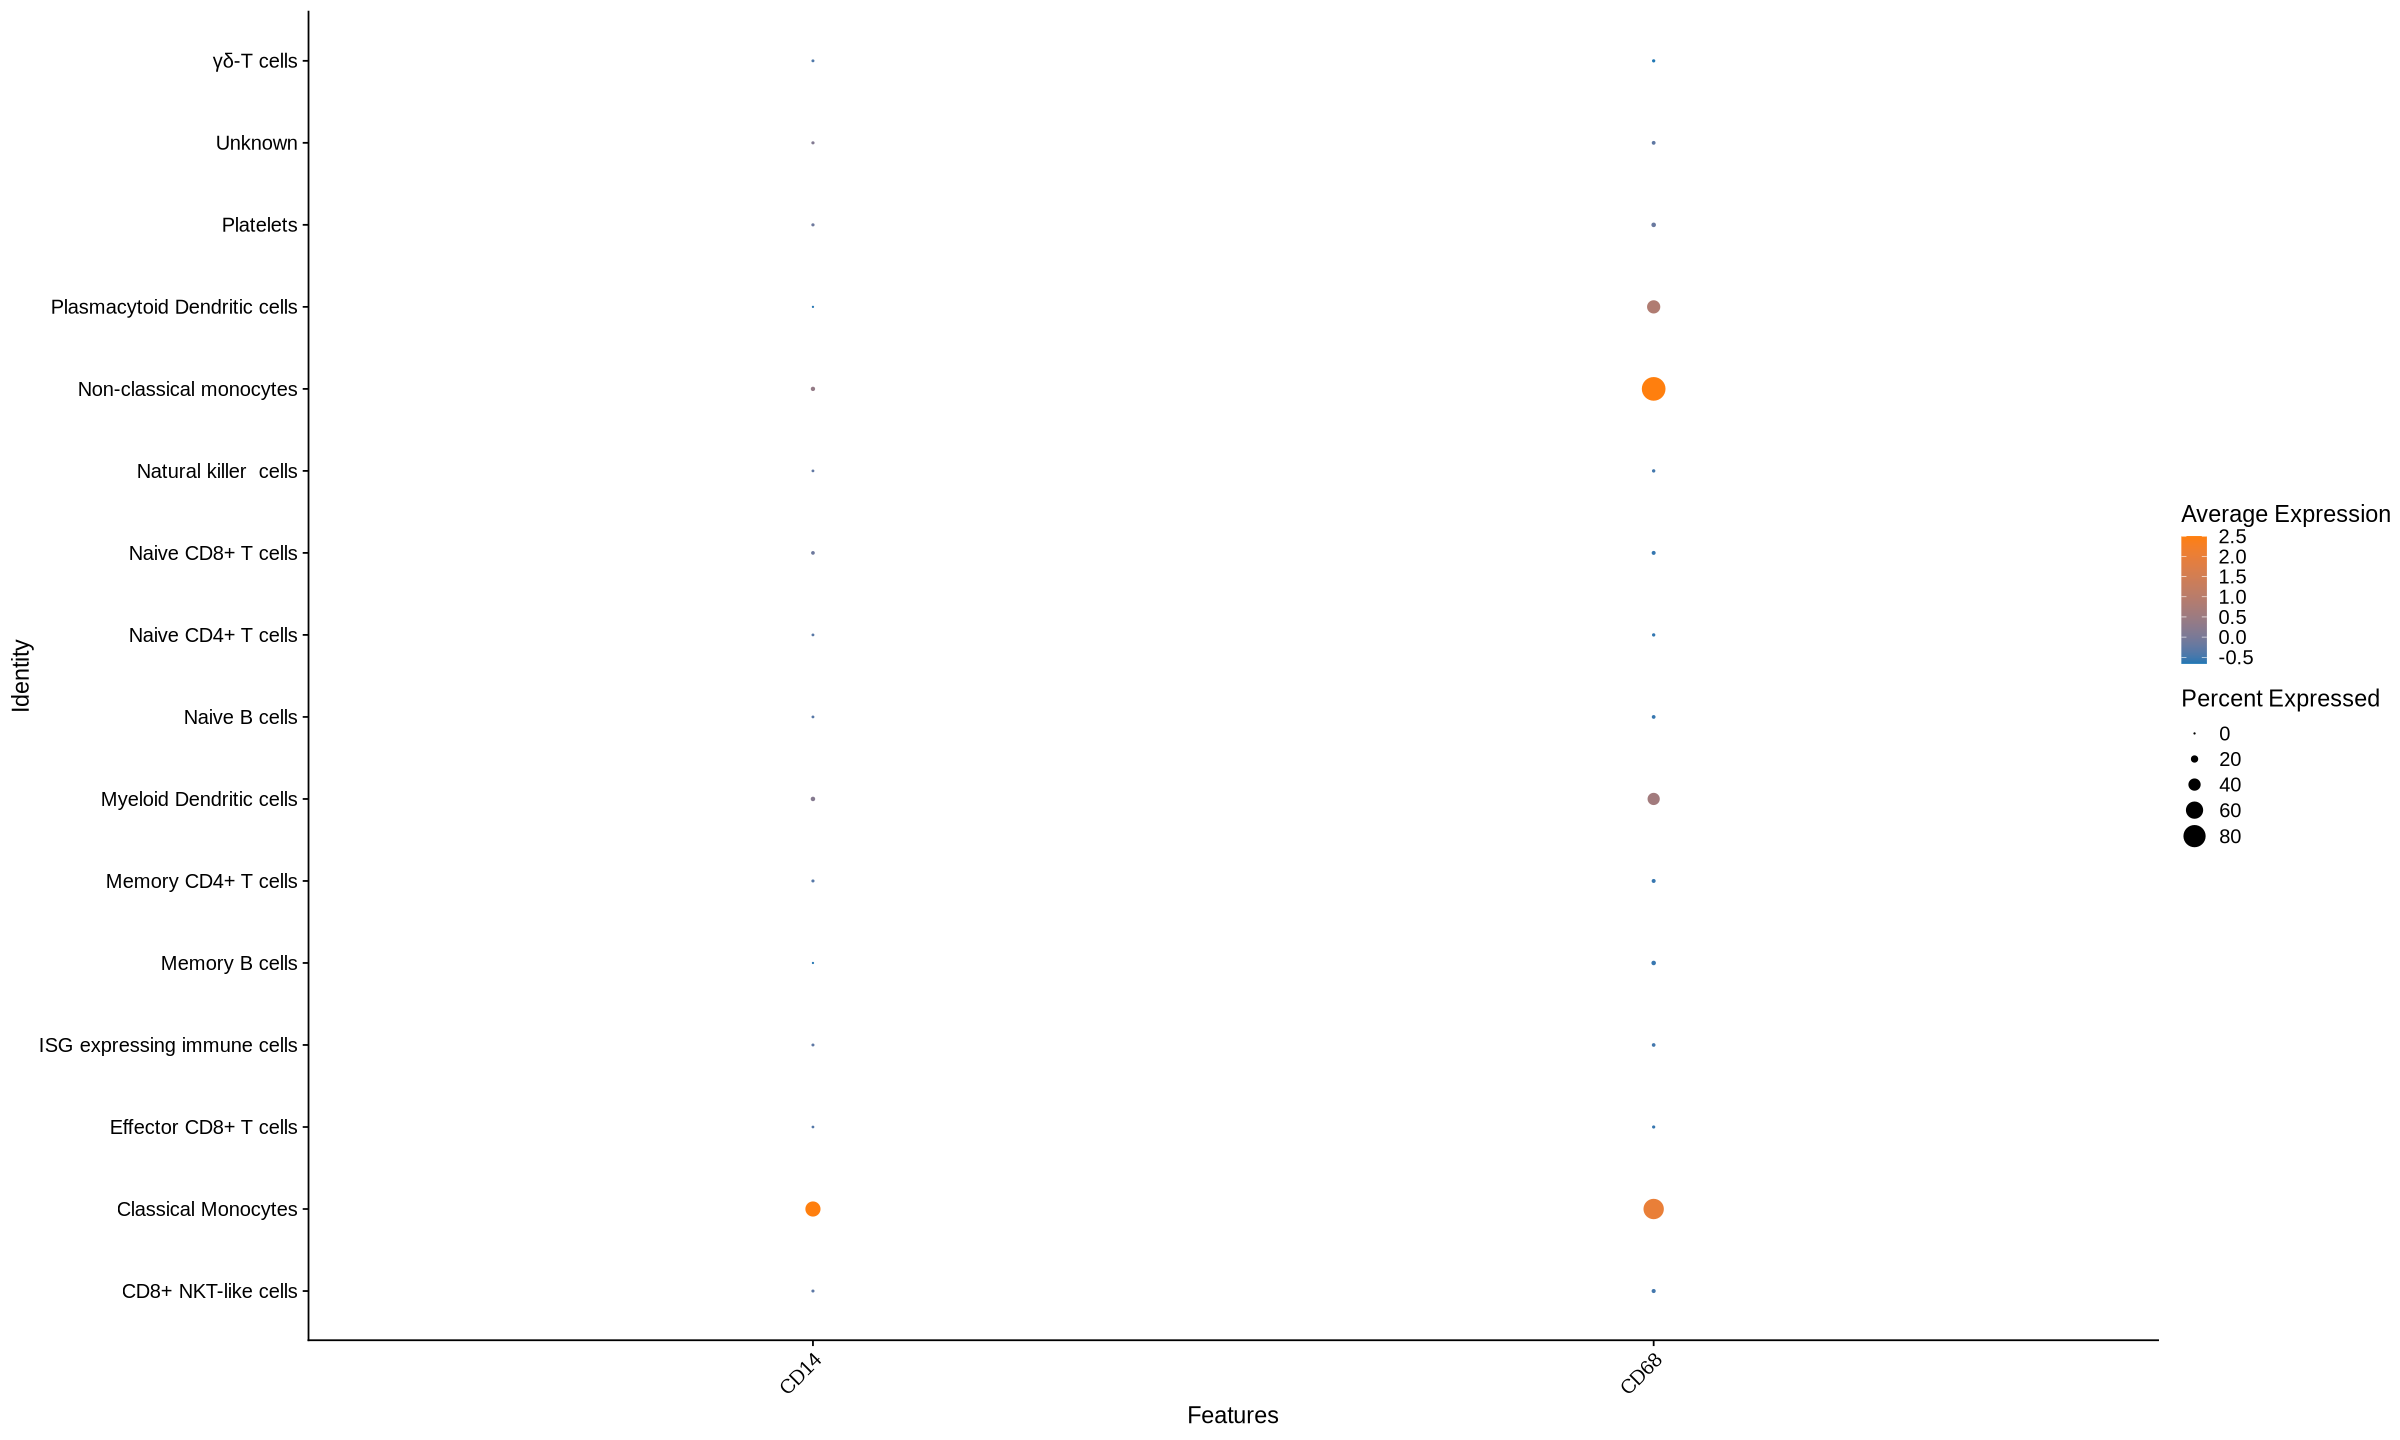

In [20]:
DotPlot(seur_obj, features = monocytes_rna_markers, group.by = "sctype_classification", cols = my_colors, assay = "RNA") + RotatedAxis()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b4>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'γδ-T cells' in 'mbcsToSbcs': dot substituted for <b3>”
Warning message in grid.Call

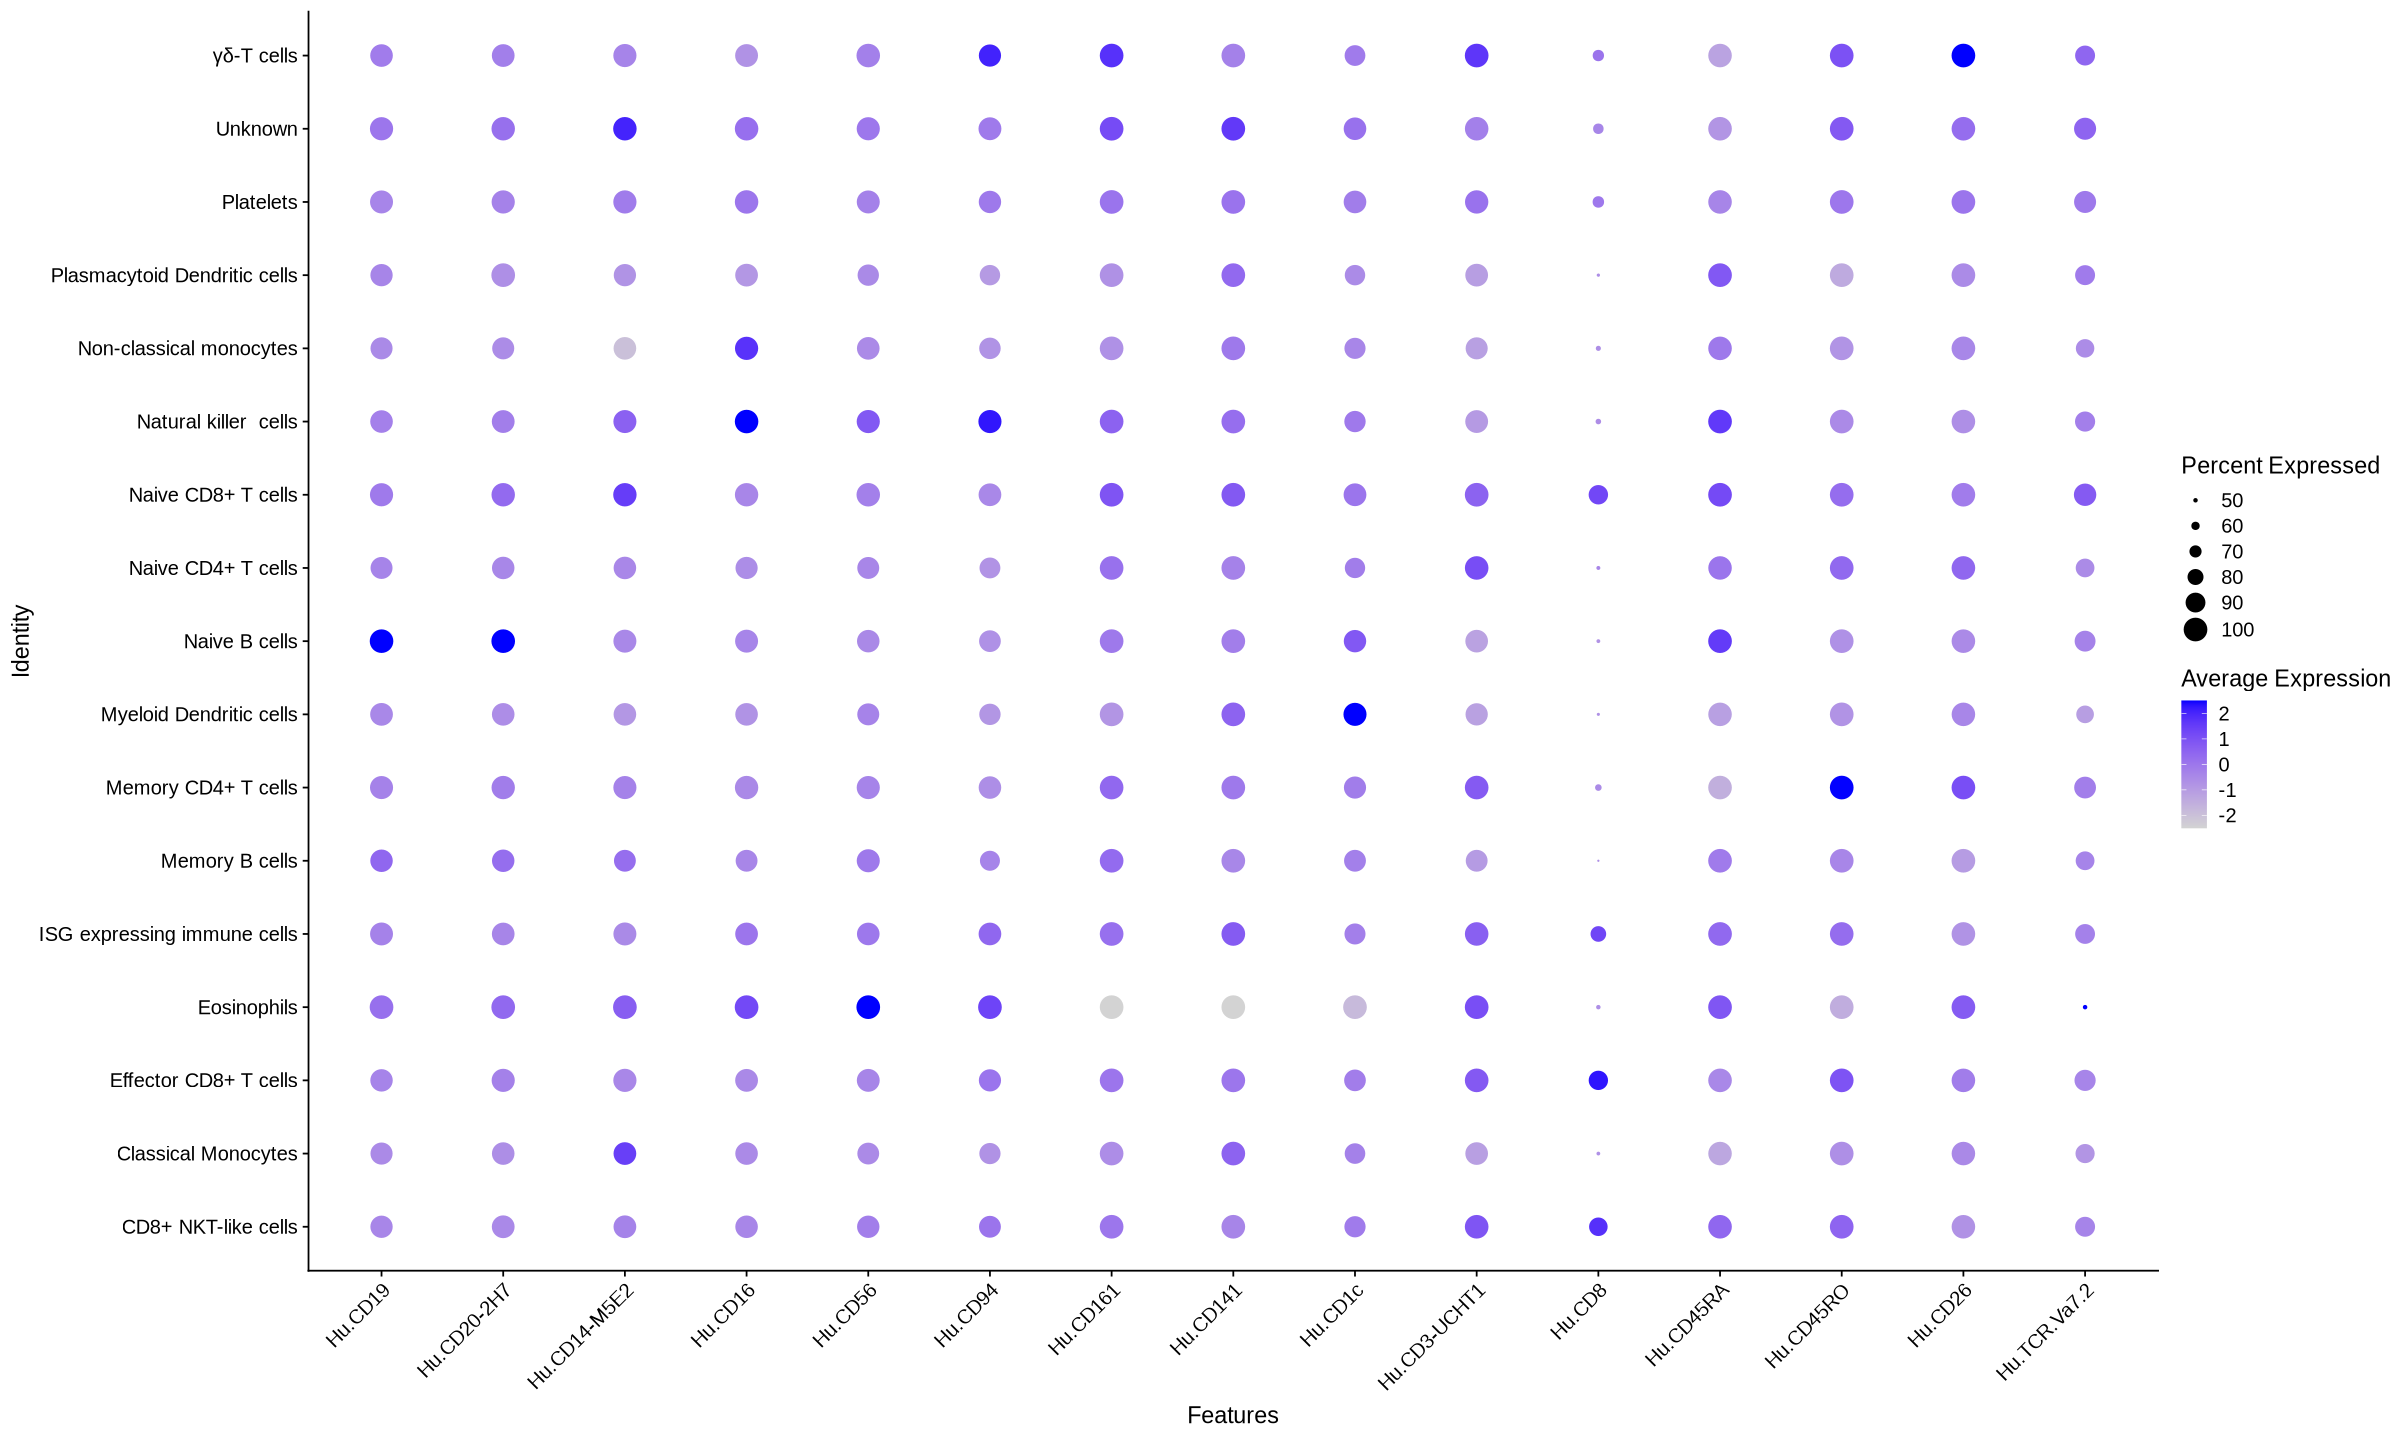

In [31]:
DotPlot(seur_obj, features = adt_markers, group.by = "sctype_classification", assay ="ADT",cols = c("lightgrey", "blue")) + RotatedAxis()
 

In [23]:
RColorBrewer::brewer.pal.info

,maxcolors,category,colorblind
,<dbl>,<chr>,<lgl>
BrBG,11,div,TRUE
PiYG,11,div,TRUE
PRGn,11,div,TRUE
PuOr,11,div,TRUE
RdBu,11,div,TRUE
RdGy,11,div,FALSE
RdYlBu,11,div,TRUE
RdYlGn,11,div,FALSE
Spectral,11,div,FALSE


In [ ]:
 
ridge_plots <- RidgePlot(
  object = seur_obj,
  features = adt_markers,
  group.by = "sctype_classification",
  assay = "ADT",
  slot = "data",
  cols = my_colors
)

# Arrange plots into 4 columns
ridge_plots + plot_layout(ncol = 2)

In [ ]:
#FeaturePlot(seur_obj, features = c("Hu.CD94"), reduction = 'adt.umap' ) 
DimPlot(seur_obj, reduction = "adt.umap", label = TRUE, repel = TRUE, group.by = 'sctype_classification', label.size = 5) +theme(legend.title = element_text(size = 16),legend.text = element_text(size = 16))     # Adjust legend label size

In [ ]:
 DotPlot(seur_obj, features = adt_markers, group.by = "sctype_classification", assay ="ADT",cols = my_colors, col.min = -1) + RotatedAxis()

In [ ]:
# Set threshold on scaled data
scaled_data <- seur_obj[["RNA"]]$scale.data


# Set threshold for scaled expression (e.g., > 0.5)
scaled_threshold <- 0.5
scaled_features <- apply(scaled_data, 1, function(x) any(x > scaled_threshold))

# Filter features
filtered_features_scaled <- features[scaled_features]

# Plot DotPlot with filtered features
DotPlot(seur_obj, features = filtered_features_scaled) + RotatedAxis()


In [ ]:
str(seur_obj)

In [ ]:
#DotPlot(seur_obj, features = c("Hu.CD8","Hu.CD16"), group.by = "sctype_classification",assay ="ADT", cols = my_colors) + RotatedAxis()


In [ ]:
RidgePlot(seur_obj, "CD8A" , group.by = "sctype_classification")  

In [ ]:
# load libraries
lapply(c("ggraph","igraph", "data.tree"), library, character.only = T)
#lapply(c("ggraph","igraph","tidyverse", "data.tree"), library, character.only = T)


In [ ]:
    reference <- readRDS("/share/hennlab/projects/NCR_scRNAseq/data/pbmc_multimodal_2023.rds")

In [ ]:
anchors <- FindTransferAnchors(
  reference = reference,
  query = seur_obj,
  normalization.method = "SCT",
  reference.reduction = "spca",
  dims = 1:50
)

In [ ]:
seur_obj_mapped <- MapQuery(
  anchorset = anchors,
  query = seur_obj,
  reference = reference,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"
  ),
  reference.reduction = "spca", 
  reduction.model = "wnn.umap"
)

In [ ]:
p1 = DimPlot(seur_obj_mapped, reduction = "ref.umap", group.by = "predicted.celltype.l1", label = TRUE, label.size = 3, repel = TRUE)  
p2 = DimPlot(seur_obj_mapped, reduction = "ref.umap", group.by = "predicted.celltype.l2", label = TRUE, label.size = 3 ,repel = TRUE)  
p1 + p2